First, import libraries and define functions (to hang out in global scope).

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt

import csv
from collections import defaultdict

def plot_weights(model):
    for layer in model.layers:
        W = layer.get_weights()[0]

        for i in range(W.shape[2]):
            for j in range(W.shape[3]):
                print(W[:,:,i,j])
                plt.subplot(W.shape[2], W.shape[3], 1+j+i*W.shape[3])
                plt.imshow((W[:,:,i,j]+1)/2, cmap="gray")
        plt.show()

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def show_board(board):
    for row in board:
        for piece in row:
            if piece[2]:
                letter = 'K'
            elif piece[3]:
                letter = 'Q'
            elif piece[4]:
                letter = 'R'
            elif piece[5]:
                letter = 'N'
            elif piece[6]:
                letter = 'B'
            elif piece[7]:
                letter = 'P'
            else:
                letter = '.'

            if piece[1]:
                letter = letter.lower()

            print(letter, end='')
        print()

def show_moves(moves):
    for row in moves:
        for move in row:
            move = 'X' if move[0] else '.'
            print(move, end='')
        print()

print("Done importing.")

Done importing.


Next, define handcrafted filters and data representation specifications.

In [2]:
FILTERS = {
    'neutral': np.zeros((3,3,1)),
}
for j in range(3):
    for i in range(3):
        filter = np.zeros((3,3,1))
        filter[i][j] = 1
        FILTERS['pos'+str(i+j*3)] = filter
        
        
# def make_weight(filters):
    

# WEIGHTS = {
#     'whitebishop': make_weight({'white':'pos4','bishop':'pos4'})
    
#     [np.array(
#             #   Wh   Bl    K    Q    R    N    B    P   mv   ep
#             [[[[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]]],
#              [[[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 2],[ 0],[ 0],[ 0],[ 0],[ 0],[ 2],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]]],
#              [[[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]]]]
#         ),
#         np.array([-3])],
#     'pos0_whitebishop': [np.array(
#             #   Wh   Bl    K    Q    R    N    B    P   mv   ep   wb
#             [[[[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 1]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]]],
#              [[[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]]],
#              [[[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]]]]
#         ),
#         np.array([0])],
# }

# WEIGHTS['whitebishop'] = 

TRAINING_SIZE = 19000
TOTAL_SIZE = 31000

piece_to_id = {
	'K':[1,0,0,0,0,0],
	'Q':[0,1,0,0,0,0],
	'R':[0,0,1,0,0,0],
	'N':[0,0,0,1,0,0],
	'B':[0,0,0,0,1,0],
	'P':[0,0,0,0,0,1],
}

LAYERS = [
    'white',
    'black',
    'king',
    'queen',
    'rook',
    'knight',
    'bishop',
    'pawn',
    'has_moved',
    'enpassant',
]

cache = defaultdict(str)

print("Ok.")

Ok.


Import training data!

In [5]:
X = []
Y = []
i = 0
for line in csv.reader(open('moves.csv'), delimiter='|'):
    i+= 1
    if i > TOTAL_SIZE:
        break

    player = 1 if int(line[0]) == 1 else 0
    if not player:
        continue

    found_bishop=False

    colors = [[1,0]]*16 + [[0,1]]*16
    pieces = [piece_to_id[char] for char in line[2].split(',')]
    has_moved = [([1] if n!='0' else [0]) for n in line[3].split(',')]
    enpassant = [[0]]*32
    if line[4]:
        enpassant[int(line[4])-1] = [1]

    squares = []
    for row in chunks(line[1].split(','), 8):
        rank = []
        for id in row:
            if not id:
                square = [0,0] + [0]*6 + [0] + [0]
            else:
                id = int(id)-1
                if pieces[id] == [0,0,0,0,1,0]:
                    found_bishop = True
                square = colors[id] + pieces[id] + has_moved[id] + enpassant[id]
            rank.append(square)
        squares.append(rank)

    if not found_bishop:
        continue

    X.append(squares)

    destinations = []
    for line in chunks(line[5].split(','), 8):
        destinations.append([(1 if n!='0' else 0) for n in line])
    Y.append(destinations)

X = np.array(X).astype('float32')
Y = np.array(Y)
Y = np.expand_dims(Y, 3)

print(len(X))

22766


The heart of the matter! Find new features to add to the board representation.

In [6]:
model = Sequential()
model.add(Conv2D(1, (3, 3), padding='same', activation='relu', input_shape=(8,8,1)))

model.compile(
    loss=keras.losses.mean_squared_error,
    metrics=['accuracy', keras.metrics.TruePositives()]
)

best_accuracy = 0
best_TPR = 0
best_filter = ''
best_property = None
while 'neutral_white' not in LAYERS:
    for key, filter in FILTERS.items():
        model.layers[0].set_weights([
                np.expand_dims(np.array(filter), 3),
                np.array([0])
        ])
        # plot_weights(model)

        for i, X_slice in enumerate(np.split(X, X.shape[3], 3)):
            if key+'_'+LAYERS[i] in LAYERS:
                print("Already considering", key+'_'+LAYERS[i])
                continue
            if key+'_'+LAYERS[i] not in cache:
                cache[key+'_'+LAYERS[i]] = model.evaluate(X_slice, Y, verbose=0)
                print(key, LAYERS[i], 'accuracy:', cache[key+'_'+LAYERS[i]][1])
            score = cache[key+'_'+LAYERS[i]]
#             print(key, LAYERS[i], 'TPR:', score[2])
            if best_accuracy + 0.00000001 < score[1]:
                best_accuracy = score[1]
                best_property = i
                best_filter = key
            if key=='neutral':
                break

    if best_filter+'_'+LAYERS[best_property] in LAYERS:
        print("Could not improve result with basic filters.")
        break
                
    print(best_filter, 'got an accuracy of', best_accuracy, 'on', LAYERS[best_property])

    model.layers[0].set_weights([
        np.expand_dims(np.array(FILTERS[best_filter]), 3),
        np.array([0])
    ])

    Y_prob = (model.predict(np.split(X, X.shape[3], 3)[best_property]) > .5).astype('int')

    for i, y_prob in enumerate(Y_prob):
        if not (y_prob == Y[i]).all():
            show_board(X[i])
            print()
            show_moves(y_prob)
            print()
            show_moves(Y[i])
            print('-----')
            break
            
    X = np.concatenate((X, Y_prob), 3)
    LAYERS.append(best_filter+'_'+LAYERS[best_property])
    print("Appended", best_filter+'_'+LAYERS[best_property], 'to LAYERS')

pos0 got an accuracy of 0.85349315 on bishop
R.K.....
....b.r.
..P.PP.N
.P......
...NkpPp
....p.R.
...B....
...n....

........
...X..X.
........
........
........
........
........
........

........
........
.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
-----
Appended pos0_bishop to LAYERS
Already considering pos0_bishop
pos0 pos0_bishop accuracy: 0.85370934
pos1 pos0_bishop accuracy: 0.8316733
pos2 pos0_bishop accuracy: 0.82450116
pos3 pos0_bishop accuracy: 0.8314242
pos4 pos0_bishop accuracy: 0.85349315
pos5 pos0_bishop accuracy: 0.8259397
pos6 pos0_bishop accuracy: 0.8244332
pos7 pos0_bishop accuracy: 0.8259274
pos8 pos0_bishop accuracy: 0.82208115
pos0 got an accuracy of 0.85370934 on pos0_bishop
R.K.....
....b.r.
..P.PP.N
.P......
...NkpPp
....p.R.
...B....
...n....

........
........
....X..X
........
........
........
........
........

........
........
.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
-----
Appended pos0_pos0_bishop to LAYERS
Already considering p

Use the generated board representation to train a simple network that finds the final answer.

In [16]:
X_train = X[:TRAINING_SIZE]
Y_train = Y[:TRAINING_SIZE]
X_test  = X[TRAINING_SIZE:]
Y_test  = Y[TRAINING_SIZE:]

model = Sequential()
model.add(Conv2D(5, (3, 3), padding='same', activation='relu', input_shape=X[0].shape))
model.add(Conv2D(1, (3, 3), padding='same', activation='relu'))

model.compile(
    loss=keras.losses.mean_squared_error,
#     optimizer=keras.optimizers.Adam(
#         learning_rate=0.1,
#         beta_1=0.9,
#         beta_2=0.999,
#         amsgrad=False,
#     ),
    optimizer=keras.optimizers.SGD(lr=0.01, nesterov=True)
#     optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)
model = load_model('best_model.h5')
history = model.fit(
    X_train,
    Y_train,
    batch_size=128,
    epochs=5000,
    verbose=1,
    validation_data=(X_test, Y_test),
    shuffle=True,
    callbacks = [
        ModelCheckpoint(
            filepath='best_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1,
        )]
)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Train on 19000 samples, validate on 3766 samples
Epoch 1/5000
17024/19000 [=========================>....] - ETA: 0s - loss: 0.0615 - accuracy: 0.9342
Epoch 00001: val_loss improved from inf to 0.06745, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0616 - accuracy: 0.9341 - val_loss: 0.0674 - val_accuracy: 0.9274
Epoch 2/5000
16768/19000 [=========================>....] - ETA: 0s - loss: 0.0616 - accuracy: 0.9342
Epoch 00002: val_loss improved from 0.06745 to 0.06744, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0616 - accuracy: 0.9342 - val_loss: 0.0674 - val_accuracy: 0.9274
Epoch 3/5000
17024/19000 [=========================>....] - ETA: 0s - loss: 0.0617 - accuracy: 0.9340
Epoch 00003: val_loss improved from 0.06744 to 0.06744, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0615 - accuracy: 0.9342 - val_loss: 0.0674 

Epoch 26/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0612 - accuracy: 0.9345
Epoch 00026: val_loss improved from 0.06730 to 0.06729, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0614 - accuracy: 0.9343 - val_loss: 0.0673 - val_accuracy: 0.9277
Epoch 27/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0614 - accuracy: 0.9343
Epoch 00027: val_loss improved from 0.06729 to 0.06729, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0614 - accuracy: 0.9343 - val_loss: 0.0673 - val_accuracy: 0.9277
Epoch 28/5000
16256/19000 [========================>.....] - ETA: 0s - loss: 0.0613 - accuracy: 0.9344
Epoch 00028: val_loss improved from 0.06729 to 0.06728, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0614 - accuracy: 0.9343 - val_loss: 0.0673 - val_accuracy: 0.9277
Epoch 29/5000
17152

16512/19000 [=========================>....] - ETA: 0s - loss: 0.0612 - accuracy: 0.9346
Epoch 00051: val_loss improved from 0.06714 to 0.06714, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0613 - accuracy: 0.9345 - val_loss: 0.0671 - val_accuracy: 0.9279
Epoch 52/5000
16768/19000 [=========================>....] - ETA: 0s - loss: 0.0615 - accuracy: 0.9343
Epoch 00052: val_loss improved from 0.06714 to 0.06713, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0613 - accuracy: 0.9345 - val_loss: 0.0671 - val_accuracy: 0.9279
Epoch 53/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9345
Epoch 00053: val_loss improved from 0.06713 to 0.06713, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0613 - accuracy: 0.9346 - val_loss: 0.0671 - val_accuracy: 0.9279
Epoch 54/5000
16896/19000 [======

16512/19000 [=========================>....] - ETA: 0s - loss: 0.0610 - accuracy: 0.9349
Epoch 00076: val_loss improved from 0.06699 to 0.06699, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0611 - accuracy: 0.9347 - val_loss: 0.0670 - val_accuracy: 0.9281
Epoch 77/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0612 - accuracy: 0.9346
Epoch 00077: val_loss improved from 0.06699 to 0.06698, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0611 - accuracy: 0.9347 - val_loss: 0.0670 - val_accuracy: 0.9281
Epoch 78/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0613 - accuracy: 0.9345
Epoch 00078: val_loss improved from 0.06698 to 0.06698, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0611 - accuracy: 0.9347 - val_loss: 0.0670 - val_accuracy: 0.9281
Epoch 79/5000
16896/19000 [======

16896/19000 [=========================>....] - ETA: 0s - loss: 0.0611 - accuracy: 0.9349
Epoch 00101: val_loss improved from 0.06685 to 0.06684, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0610 - accuracy: 0.9349 - val_loss: 0.0668 - val_accuracy: 0.9283
Epoch 102/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9349
Epoch 00102: val_loss improved from 0.06684 to 0.06684, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0610 - accuracy: 0.9349 - val_loss: 0.0668 - val_accuracy: 0.9283
Epoch 103/5000
18304/19000 [===========================>..] - ETA: 0s - loss: 0.0610 - accuracy: 0.9349
Epoch 00103: val_loss improved from 0.06684 to 0.06683, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0610 - accuracy: 0.9349 - val_loss: 0.0668 - val_accuracy: 0.9283
Epoch 104/5000
18176/19000 [===

17280/19000 [==========================>...] - ETA: 0s - loss: 0.0609 - accuracy: 0.9350
Epoch 00126: val_loss improved from 0.06671 to 0.06670, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0609 - accuracy: 0.9351 - val_loss: 0.0667 - val_accuracy: 0.9285
Epoch 127/5000
16768/19000 [=========================>....] - ETA: 0s - loss: 0.0608 - accuracy: 0.9352
Epoch 00127: val_loss improved from 0.06670 to 0.06670, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0609 - accuracy: 0.9351 - val_loss: 0.0667 - val_accuracy: 0.9285
Epoch 128/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0608 - accuracy: 0.9351
Epoch 00128: val_loss improved from 0.06670 to 0.06669, saving model to best_model.h5
19000/19000 [==============================] - 1s 26us/sample - loss: 0.0609 - accuracy: 0.9351 - val_loss: 0.0667 - val_accuracy: 0.9285
Epoch 129/5000
17408/19000 [===

17280/19000 [==========================>...] - ETA: 0s - loss: 0.0608 - accuracy: 0.9351
Epoch 00151: val_loss improved from 0.06657 to 0.06656, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0607 - accuracy: 0.9352 - val_loss: 0.0666 - val_accuracy: 0.9286
Epoch 152/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0607 - accuracy: 0.9352
Epoch 00152: val_loss improved from 0.06656 to 0.06656, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0607 - accuracy: 0.9352 - val_loss: 0.0666 - val_accuracy: 0.9286
Epoch 153/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9352
Epoch 00153: val_loss improved from 0.06656 to 0.06655, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0607 - accuracy: 0.9352 - val_loss: 0.0666 - val_accuracy: 0.9286
Epoch 154/5000
18176/19000 [===

17408/19000 [==========================>...] - ETA: 0s - loss: 0.0605 - accuracy: 0.9356
Epoch 00176: val_loss improved from 0.06643 to 0.06643, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0606 - accuracy: 0.9354 - val_loss: 0.0664 - val_accuracy: 0.9287
Epoch 177/5000
16384/19000 [========================>.....] - ETA: 0s - loss: 0.0606 - accuracy: 0.9354
Epoch 00177: val_loss improved from 0.06643 to 0.06642, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0606 - accuracy: 0.9354 - val_loss: 0.0664 - val_accuracy: 0.9287
Epoch 178/5000
16512/19000 [=========================>....] - ETA: 0s - loss: 0.0606 - accuracy: 0.9354
Epoch 00178: val_loss improved from 0.06642 to 0.06642, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0606 - accuracy: 0.9354 - val_loss: 0.0664 - val_accuracy: 0.9288
Epoch 179/5000
16640/19000 [===

17664/19000 [==========================>...] - ETA: 0s - loss: 0.0605 - accuracy: 0.9356
Epoch 00201: val_loss improved from 0.06630 to 0.06630, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0605 - accuracy: 0.9356 - val_loss: 0.0663 - val_accuracy: 0.9290
Epoch 202/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0604 - accuracy: 0.9356
Epoch 00202: val_loss improved from 0.06630 to 0.06629, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0605 - accuracy: 0.9356 - val_loss: 0.0663 - val_accuracy: 0.9290
Epoch 203/5000
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0605 - accuracy: 0.9356
Epoch 00203: val_loss improved from 0.06629 to 0.06629, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0605 - accuracy: 0.9356 - val_loss: 0.0663 - val_accuracy: 0.9290
Epoch 204/5000
17024/19000 [===

17920/19000 [===========================>..] - ETA: 0s - loss: 0.0602 - accuracy: 0.9358
Epoch 00226: val_loss improved from 0.06617 to 0.06617, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0604 - accuracy: 0.9357 - val_loss: 0.0662 - val_accuracy: 0.9292
Epoch 227/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0603 - accuracy: 0.9357
Epoch 00227: val_loss improved from 0.06617 to 0.06616, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0604 - accuracy: 0.9357 - val_loss: 0.0662 - val_accuracy: 0.9292
Epoch 228/5000
18432/19000 [============================>.] - ETA: 0s - loss: 0.0603 - accuracy: 0.9357
Epoch 00228: val_loss improved from 0.06616 to 0.06616, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0604 - accuracy: 0.9357 - val_loss: 0.0662 - val_accuracy: 0.9292
Epoch 229/5000
18816/19000 [===

17792/19000 [===========================>..] - ETA: 0s - loss: 0.0602 - accuracy: 0.9358
Epoch 00251: val_loss improved from 0.06605 to 0.06604, saving model to best_model.h5
19000/19000 [==============================] - 1s 36us/sample - loss: 0.0603 - accuracy: 0.9358 - val_loss: 0.0660 - val_accuracy: 0.9293
Epoch 252/5000
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0602 - accuracy: 0.9359
Epoch 00252: val_loss improved from 0.06604 to 0.06604, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0603 - accuracy: 0.9358 - val_loss: 0.0660 - val_accuracy: 0.9293
Epoch 253/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0603 - accuracy: 0.9358
Epoch 00253: val_loss improved from 0.06604 to 0.06603, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0602 - accuracy: 0.9358 - val_loss: 0.0660 - val_accuracy: 0.9293
Epoch 254/5000
17664/19000 [===

17792/19000 [===========================>..] - ETA: 0s - loss: 0.0601 - accuracy: 0.9359
Epoch 00276: val_loss improved from 0.06592 to 0.06592, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0601 - accuracy: 0.9359 - val_loss: 0.0659 - val_accuracy: 0.9294
Epoch 277/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0602 - accuracy: 0.9357
Epoch 00277: val_loss improved from 0.06592 to 0.06591, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0601 - accuracy: 0.9359 - val_loss: 0.0659 - val_accuracy: 0.9294
Epoch 278/5000
16512/19000 [=========================>....] - ETA: 0s - loss: 0.0600 - accuracy: 0.9360
Epoch 00278: val_loss improved from 0.06591 to 0.06591, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0601 - accuracy: 0.9359 - val_loss: 0.0659 - val_accuracy: 0.9294
Epoch 279/5000
16640/19000 [===

16896/19000 [=========================>....] - ETA: 0s - loss: 0.0599 - accuracy: 0.9361
Epoch 00301: val_loss improved from 0.06580 to 0.06580, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0600 - accuracy: 0.9360 - val_loss: 0.0658 - val_accuracy: 0.9296
Epoch 302/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0600 - accuracy: 0.9360
Epoch 00302: val_loss improved from 0.06580 to 0.06579, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0600 - accuracy: 0.9360 - val_loss: 0.0658 - val_accuracy: 0.9295
Epoch 303/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0601 - accuracy: 0.9359
Epoch 00303: val_loss improved from 0.06579 to 0.06579, saving model to best_model.h5
19000/19000 [==============================] - 1s 35us/sample - loss: 0.0600 - accuracy: 0.9360 - val_loss: 0.0658 - val_accuracy: 0.9296
Epoch 304/5000
17152/19000 [===

18560/19000 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.9361
Epoch 00326: val_loss improved from 0.06569 to 0.06568, saving model to best_model.h5
19000/19000 [==============================] - 1s 41us/sample - loss: 0.0599 - accuracy: 0.9361 - val_loss: 0.0657 - val_accuracy: 0.9297
Epoch 327/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0599 - accuracy: 0.9361
Epoch 00327: val_loss improved from 0.06568 to 0.06568, saving model to best_model.h5
19000/19000 [==============================] - 1s 32us/sample - loss: 0.0599 - accuracy: 0.9361 - val_loss: 0.0657 - val_accuracy: 0.9297
Epoch 328/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0600 - accuracy: 0.9360
Epoch 00328: val_loss improved from 0.06568 to 0.06567, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0599 - accuracy: 0.9361 - val_loss: 0.0657 - val_accuracy: 0.9297
Epoch 329/5000
17408/19000 [===

17280/19000 [==========================>...] - ETA: 0s - loss: 0.0597 - accuracy: 0.9363
Epoch 00351: val_loss improved from 0.06557 to 0.06556, saving model to best_model.h5
19000/19000 [==============================] - 1s 34us/sample - loss: 0.0598 - accuracy: 0.9363 - val_loss: 0.0656 - val_accuracy: 0.9299
Epoch 352/5000
16768/19000 [=========================>....] - ETA: 0s - loss: 0.0599 - accuracy: 0.9362
Epoch 00352: val_loss improved from 0.06556 to 0.06556, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0598 - accuracy: 0.9363 - val_loss: 0.0656 - val_accuracy: 0.9299
Epoch 353/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9363
Epoch 00353: val_loss improved from 0.06556 to 0.06556, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0598 - accuracy: 0.9363 - val_loss: 0.0656 - val_accuracy: 0.9299
Epoch 354/5000
17920/19000 [===

18432/19000 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9363
Epoch 00376: val_loss improved from 0.06546 to 0.06545, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0597 - accuracy: 0.9364 - val_loss: 0.0655 - val_accuracy: 0.9300
Epoch 377/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9363
Epoch 00377: val_loss improved from 0.06545 to 0.06545, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0597 - accuracy: 0.9364 - val_loss: 0.0654 - val_accuracy: 0.9300
Epoch 378/5000
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0597 - accuracy: 0.9363
Epoch 00378: val_loss improved from 0.06545 to 0.06544, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0597 - accuracy: 0.9364 - val_loss: 0.0654 - val_accuracy: 0.9300
Epoch 379/5000
18688/19000 [===

17024/19000 [=========================>....] - ETA: 0s - loss: 0.0596 - accuracy: 0.9364
Epoch 00401: val_loss improved from 0.06535 to 0.06534, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0596 - accuracy: 0.9365 - val_loss: 0.0653 - val_accuracy: 0.9300
Epoch 402/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0596 - accuracy: 0.9364
Epoch 00402: val_loss improved from 0.06534 to 0.06534, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0596 - accuracy: 0.9365 - val_loss: 0.0653 - val_accuracy: 0.9301
Epoch 403/5000
17024/19000 [=========================>....] - ETA: 0s - loss: 0.0595 - accuracy: 0.9366
Epoch 00403: val_loss improved from 0.06534 to 0.06533, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0596 - accuracy: 0.9365 - val_loss: 0.0653 - val_accuracy: 0.9301
Epoch 404/5000
17792/19000 [===

17152/19000 [==========================>...] - ETA: 0s - loss: 0.0595 - accuracy: 0.9367
Epoch 00426: val_loss improved from 0.06524 to 0.06523, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0595 - accuracy: 0.9366 - val_loss: 0.0652 - val_accuracy: 0.9302
Epoch 427/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0595 - accuracy: 0.9366
Epoch 00427: val_loss improved from 0.06523 to 0.06523, saving model to best_model.h5
19000/19000 [==============================] - 1s 26us/sample - loss: 0.0595 - accuracy: 0.9366 - val_loss: 0.0652 - val_accuracy: 0.9302
Epoch 428/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0595 - accuracy: 0.9366
Epoch 00428: val_loss improved from 0.06523 to 0.06522, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0595 - accuracy: 0.9366 - val_loss: 0.0652 - val_accuracy: 0.9302
Epoch 429/5000
18048/19000 [===

17408/19000 [==========================>...] - ETA: 0s - loss: 0.0596 - accuracy: 0.9364
Epoch 00451: val_loss improved from 0.06513 to 0.06512, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0594 - accuracy: 0.9367 - val_loss: 0.0651 - val_accuracy: 0.9302
Epoch 452/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0595 - accuracy: 0.9366
Epoch 00452: val_loss improved from 0.06512 to 0.06512, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0594 - accuracy: 0.9367 - val_loss: 0.0651 - val_accuracy: 0.9302
Epoch 453/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0592 - accuracy: 0.9369
Epoch 00453: val_loss improved from 0.06512 to 0.06512, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0594 - accuracy: 0.9367 - val_loss: 0.0651 - val_accuracy: 0.9302
Epoch 454/5000
17920/19000 [===

17792/19000 [===========================>..] - ETA: 0s - loss: 0.0593 - accuracy: 0.9367
Epoch 00476: val_loss improved from 0.06502 to 0.06502, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0593 - accuracy: 0.9368 - val_loss: 0.0650 - val_accuracy: 0.9303
Epoch 477/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0594 - accuracy: 0.9368
Epoch 00477: val_loss improved from 0.06502 to 0.06501, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0593 - accuracy: 0.9368 - val_loss: 0.0650 - val_accuracy: 0.9303
Epoch 478/5000
16640/19000 [=========================>....] - ETA: 0s - loss: 0.0593 - accuracy: 0.9368
Epoch 00478: val_loss improved from 0.06501 to 0.06501, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0593 - accuracy: 0.9368 - val_loss: 0.0650 - val_accuracy: 0.9304
Epoch 479/5000
16640/19000 [===

16640/19000 [=========================>....] - ETA: 0s - loss: 0.0593 - accuracy: 0.9368
Epoch 00501: val_loss improved from 0.06492 to 0.06492, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0592 - accuracy: 0.9369 - val_loss: 0.0649 - val_accuracy: 0.9305
Epoch 502/5000
16640/19000 [=========================>....] - ETA: 0s - loss: 0.0590 - accuracy: 0.9371
Epoch 00502: val_loss improved from 0.06492 to 0.06491, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0592 - accuracy: 0.9369 - val_loss: 0.0649 - val_accuracy: 0.9305
Epoch 503/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0592 - accuracy: 0.9368
Epoch 00503: val_loss improved from 0.06491 to 0.06491, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0592 - accuracy: 0.9369 - val_loss: 0.0649 - val_accuracy: 0.9305
Epoch 504/5000
17024/19000 [===

17536/19000 [==========================>...] - ETA: 0s - loss: 0.0591 - accuracy: 0.9370
Epoch 00526: val_loss improved from 0.06482 to 0.06481, saving model to best_model.h5
19000/19000 [==============================] - 1s 32us/sample - loss: 0.0591 - accuracy: 0.9370 - val_loss: 0.0648 - val_accuracy: 0.9306
Epoch 527/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0591 - accuracy: 0.9369
Epoch 00527: val_loss improved from 0.06481 to 0.06481, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0591 - accuracy: 0.9370 - val_loss: 0.0648 - val_accuracy: 0.9307
Epoch 528/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0591 - accuracy: 0.9370
Epoch 00528: val_loss improved from 0.06481 to 0.06481, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0591 - accuracy: 0.9370 - val_loss: 0.0648 - val_accuracy: 0.9307
Epoch 529/5000
17536/19000 [===

17152/19000 [==========================>...] - ETA: 0s - loss: 0.0590 - accuracy: 0.9371
Epoch 00551: val_loss improved from 0.06472 to 0.06472, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0590 - accuracy: 0.9371 - val_loss: 0.0647 - val_accuracy: 0.9307
Epoch 552/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0589 - accuracy: 0.9372
Epoch 00552: val_loss improved from 0.06472 to 0.06471, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0590 - accuracy: 0.9371 - val_loss: 0.0647 - val_accuracy: 0.9307
Epoch 553/5000
16768/19000 [=========================>....] - ETA: 0s - loss: 0.0590 - accuracy: 0.9371
Epoch 00553: val_loss improved from 0.06471 to 0.06471, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0590 - accuracy: 0.9371 - val_loss: 0.0647 - val_accuracy: 0.9307
Epoch 554/5000
18944/19000 [===

17664/19000 [==========================>...] - ETA: 0s - loss: 0.0589 - accuracy: 0.9372
Epoch 00576: val_loss improved from 0.06462 to 0.06462, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0589 - accuracy: 0.9372 - val_loss: 0.0646 - val_accuracy: 0.9308
Epoch 577/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0590 - accuracy: 0.9371
Epoch 00577: val_loss improved from 0.06462 to 0.06462, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0589 - accuracy: 0.9371 - val_loss: 0.0646 - val_accuracy: 0.9308
Epoch 578/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0589 - accuracy: 0.9371
Epoch 00578: val_loss improved from 0.06462 to 0.06461, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0589 - accuracy: 0.9371 - val_loss: 0.0646 - val_accuracy: 0.9308
Epoch 579/5000
18176/19000 [===

17280/19000 [==========================>...] - ETA: 0s - loss: 0.0589 - accuracy: 0.9372
Epoch 00601: val_loss improved from 0.06453 to 0.06453, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0589 - accuracy: 0.9372 - val_loss: 0.0645 - val_accuracy: 0.9309
Epoch 602/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0588 - accuracy: 0.9373
Epoch 00602: val_loss improved from 0.06453 to 0.06452, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0589 - accuracy: 0.9372 - val_loss: 0.0645 - val_accuracy: 0.9309
Epoch 603/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0588 - accuracy: 0.9373
Epoch 00603: val_loss improved from 0.06452 to 0.06452, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0589 - accuracy: 0.9372 - val_loss: 0.0645 - val_accuracy: 0.9309
Epoch 604/5000
18560/19000 [===

17152/19000 [==========================>...] - ETA: 0s - loss: 0.0588 - accuracy: 0.9373
Epoch 00626: val_loss improved from 0.06444 to 0.06444, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0588 - accuracy: 0.9373 - val_loss: 0.0644 - val_accuracy: 0.9311
Epoch 627/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0588 - accuracy: 0.9373
Epoch 00627: val_loss improved from 0.06444 to 0.06443, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0588 - accuracy: 0.9373 - val_loss: 0.0644 - val_accuracy: 0.9311
Epoch 628/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0588 - accuracy: 0.9373
Epoch 00628: val_loss improved from 0.06443 to 0.06443, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0588 - accuracy: 0.9373 - val_loss: 0.0644 - val_accuracy: 0.9311
Epoch 629/5000
16768/19000 [===

18560/19000 [============================>.] - ETA: 0s - loss: 0.0586 - accuracy: 0.9375
Epoch 00651: val_loss improved from 0.06435 to 0.06435, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0587 - accuracy: 0.9374 - val_loss: 0.0643 - val_accuracy: 0.9311
Epoch 652/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0588 - accuracy: 0.9373
Epoch 00652: val_loss improved from 0.06435 to 0.06434, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0587 - accuracy: 0.9374 - val_loss: 0.0643 - val_accuracy: 0.9311
Epoch 653/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0587 - accuracy: 0.9374
Epoch 00653: val_loss improved from 0.06434 to 0.06434, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0587 - accuracy: 0.9374 - val_loss: 0.0643 - val_accuracy: 0.9311
Epoch 654/5000
17536/19000 [===

18432/19000 [============================>.] - ETA: 0s - loss: 0.0586 - accuracy: 0.9375
Epoch 00676: val_loss improved from 0.06426 to 0.06426, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0586 - accuracy: 0.9375 - val_loss: 0.0643 - val_accuracy: 0.9312
Epoch 677/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0586 - accuracy: 0.9375
Epoch 00677: val_loss improved from 0.06426 to 0.06426, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0586 - accuracy: 0.9375 - val_loss: 0.0643 - val_accuracy: 0.9312
Epoch 678/5000
18304/19000 [===========================>..] - ETA: 0s - loss: 0.0585 - accuracy: 0.9376
Epoch 00678: val_loss improved from 0.06426 to 0.06425, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0586 - accuracy: 0.9375 - val_loss: 0.0643 - val_accuracy: 0.9312
Epoch 679/5000
18944/19000 [===

17024/19000 [=========================>....] - ETA: 0s - loss: 0.0586 - accuracy: 0.9375
Epoch 00701: val_loss improved from 0.06418 to 0.06417, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0585 - accuracy: 0.9375 - val_loss: 0.0642 - val_accuracy: 0.9313
Epoch 702/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0585 - accuracy: 0.9375
Epoch 00702: val_loss improved from 0.06417 to 0.06417, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0585 - accuracy: 0.9375 - val_loss: 0.0642 - val_accuracy: 0.9313
Epoch 703/5000
16512/19000 [=========================>....] - ETA: 0s - loss: 0.0585 - accuracy: 0.9377
Epoch 00703: val_loss improved from 0.06417 to 0.06417, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0585 - accuracy: 0.9376 - val_loss: 0.0642 - val_accuracy: 0.9313
Epoch 704/5000
18816/19000 [===

17792/19000 [===========================>..] - ETA: 0s - loss: 0.0585 - accuracy: 0.9376
Epoch 00726: val_loss improved from 0.06409 to 0.06409, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0585 - accuracy: 0.9376 - val_loss: 0.0641 - val_accuracy: 0.9314
Epoch 727/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0584 - accuracy: 0.9376
Epoch 00727: val_loss improved from 0.06409 to 0.06409, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0585 - accuracy: 0.9376 - val_loss: 0.0641 - val_accuracy: 0.9314
Epoch 728/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0584 - accuracy: 0.9377
Epoch 00728: val_loss improved from 0.06409 to 0.06408, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0585 - accuracy: 0.9376 - val_loss: 0.0641 - val_accuracy: 0.9314
Epoch 729/5000
18560/19000 [===

17536/19000 [==========================>...] - ETA: 0s - loss: 0.0585 - accuracy: 0.9375
Epoch 00751: val_loss improved from 0.06401 to 0.06401, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0584 - accuracy: 0.9377 - val_loss: 0.0640 - val_accuracy: 0.9315
Epoch 752/5000
17024/19000 [=========================>....] - ETA: 0s - loss: 0.0584 - accuracy: 0.9377
Epoch 00752: val_loss improved from 0.06401 to 0.06400, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0584 - accuracy: 0.9377 - val_loss: 0.0640 - val_accuracy: 0.9315
Epoch 753/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0584 - accuracy: 0.9376
Epoch 00753: val_loss improved from 0.06400 to 0.06400, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0584 - accuracy: 0.9377 - val_loss: 0.0640 - val_accuracy: 0.9315
Epoch 754/5000
17152/19000 [===

17280/19000 [==========================>...] - ETA: 0s - loss: 0.0584 - accuracy: 0.9377
Epoch 00776: val_loss improved from 0.06393 to 0.06392, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0583 - accuracy: 0.9377 - val_loss: 0.0639 - val_accuracy: 0.9316
Epoch 777/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0585 - accuracy: 0.9376
Epoch 00777: val_loss improved from 0.06392 to 0.06392, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0583 - accuracy: 0.9378 - val_loss: 0.0639 - val_accuracy: 0.9316
Epoch 778/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0583 - accuracy: 0.9378
Epoch 00778: val_loss improved from 0.06392 to 0.06392, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0583 - accuracy: 0.9377 - val_loss: 0.0639 - val_accuracy: 0.9316
Epoch 779/5000
17280/19000 [===

18176/19000 [===========================>..] - ETA: 0s - loss: 0.0582 - accuracy: 0.9378
Epoch 00801: val_loss improved from 0.06385 to 0.06385, saving model to best_model.h5
19000/19000 [==============================] - 1s 35us/sample - loss: 0.0582 - accuracy: 0.9378 - val_loss: 0.0638 - val_accuracy: 0.9317
Epoch 802/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0582 - accuracy: 0.9378
Epoch 00802: val_loss improved from 0.06385 to 0.06384, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0582 - accuracy: 0.9378 - val_loss: 0.0638 - val_accuracy: 0.9317
Epoch 803/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0582 - accuracy: 0.9379
Epoch 00803: val_loss improved from 0.06384 to 0.06384, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0582 - accuracy: 0.9378 - val_loss: 0.0638 - val_accuracy: 0.9317
Epoch 804/5000
17024/19000 [===

18432/19000 [============================>.] - ETA: 0s - loss: 0.0582 - accuracy: 0.9378
Epoch 00826: val_loss improved from 0.06377 to 0.06377, saving model to best_model.h5
19000/19000 [==============================] - 1s 34us/sample - loss: 0.0582 - accuracy: 0.9379 - val_loss: 0.0638 - val_accuracy: 0.9317
Epoch 827/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0582 - accuracy: 0.9378
Epoch 00827: val_loss improved from 0.06377 to 0.06377, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0582 - accuracy: 0.9379 - val_loss: 0.0638 - val_accuracy: 0.9318
Epoch 828/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0582 - accuracy: 0.9378
Epoch 00828: val_loss improved from 0.06377 to 0.06376, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0582 - accuracy: 0.9379 - val_loss: 0.0638 - val_accuracy: 0.9317
Epoch 829/5000
17408/19000 [===

17408/19000 [==========================>...] - ETA: 0s - loss: 0.0579 - accuracy: 0.9380
Epoch 00851: val_loss improved from 0.06370 to 0.06369, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0581 - accuracy: 0.9379 - val_loss: 0.0637 - val_accuracy: 0.9318
Epoch 852/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0581 - accuracy: 0.9379
Epoch 00852: val_loss improved from 0.06369 to 0.06369, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0581 - accuracy: 0.9379 - val_loss: 0.0637 - val_accuracy: 0.9318
Epoch 853/5000
16768/19000 [=========================>....] - ETA: 0s - loss: 0.0580 - accuracy: 0.9379
Epoch 00853: val_loss improved from 0.06369 to 0.06369, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0581 - accuracy: 0.9379 - val_loss: 0.0637 - val_accuracy: 0.9318
Epoch 854/5000
17664/19000 [===

16768/19000 [=========================>....] - ETA: 0s - loss: 0.0580 - accuracy: 0.9380
Epoch 00876: val_loss improved from 0.06362 to 0.06362, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0580 - accuracy: 0.9379 - val_loss: 0.0636 - val_accuracy: 0.9318
Epoch 877/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0580 - accuracy: 0.9379
Epoch 00877: val_loss improved from 0.06362 to 0.06361, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0580 - accuracy: 0.9380 - val_loss: 0.0636 - val_accuracy: 0.9319
Epoch 878/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0580 - accuracy: 0.9380
Epoch 00878: val_loss improved from 0.06361 to 0.06361, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0580 - accuracy: 0.9380 - val_loss: 0.0636 - val_accuracy: 0.9319
Epoch 879/5000
16640/19000 [===

18304/19000 [===========================>..] - ETA: 0s - loss: 0.0579 - accuracy: 0.9380
Epoch 00901: val_loss improved from 0.06355 to 0.06354, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0579 - accuracy: 0.9380 - val_loss: 0.0635 - val_accuracy: 0.9320
Epoch 902/5000
16256/19000 [========================>.....] - ETA: 0s - loss: 0.0580 - accuracy: 0.9379
Epoch 00902: val_loss improved from 0.06354 to 0.06354, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0579 - accuracy: 0.9380 - val_loss: 0.0635 - val_accuracy: 0.9320
Epoch 903/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0578 - accuracy: 0.9382
Epoch 00903: val_loss improved from 0.06354 to 0.06354, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0579 - accuracy: 0.9380 - val_loss: 0.0635 - val_accuracy: 0.9320
Epoch 904/5000
17792/19000 [===

18816/19000 [============================>.] - ETA: 0s - loss: 0.0579 - accuracy: 0.9381
Epoch 00926: val_loss improved from 0.06347 to 0.06347, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0579 - accuracy: 0.9381 - val_loss: 0.0635 - val_accuracy: 0.9321
Epoch 927/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0579 - accuracy: 0.9380
Epoch 00927: val_loss improved from 0.06347 to 0.06347, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0579 - accuracy: 0.9381 - val_loss: 0.0635 - val_accuracy: 0.9321
Epoch 928/5000
17024/19000 [=========================>....] - ETA: 0s - loss: 0.0579 - accuracy: 0.9381
Epoch 00928: val_loss improved from 0.06347 to 0.06347, saving model to best_model.h5
19000/19000 [==============================] - 1s 32us/sample - loss: 0.0579 - accuracy: 0.9381 - val_loss: 0.0635 - val_accuracy: 0.9321
Epoch 929/5000
18432/19000 [===

17024/19000 [=========================>....] - ETA: 0s - loss: 0.0579 - accuracy: 0.9380
Epoch 00951: val_loss improved from 0.06340 to 0.06340, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0578 - accuracy: 0.9381 - val_loss: 0.0634 - val_accuracy: 0.9321
Epoch 952/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0578 - accuracy: 0.9381
Epoch 00952: val_loss improved from 0.06340 to 0.06340, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0578 - accuracy: 0.9381 - val_loss: 0.0634 - val_accuracy: 0.9321
Epoch 953/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0579 - accuracy: 0.9381
Epoch 00953: val_loss improved from 0.06340 to 0.06339, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0578 - accuracy: 0.9381 - val_loss: 0.0634 - val_accuracy: 0.9321
Epoch 954/5000
16896/19000 [===

18176/19000 [===========================>..] - ETA: 0s - loss: 0.0577 - accuracy: 0.9382
Epoch 00976: val_loss improved from 0.06333 to 0.06333, saving model to best_model.h5
19000/19000 [==============================] - 1s 41us/sample - loss: 0.0577 - accuracy: 0.9381 - val_loss: 0.0633 - val_accuracy: 0.9322
Epoch 977/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0577 - accuracy: 0.9382
Epoch 00977: val_loss improved from 0.06333 to 0.06333, saving model to best_model.h5
19000/19000 [==============================] - 1s 40us/sample - loss: 0.0577 - accuracy: 0.9381 - val_loss: 0.0633 - val_accuracy: 0.9322
Epoch 978/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0576 - accuracy: 0.9383
Epoch 00978: val_loss improved from 0.06333 to 0.06332, saving model to best_model.h5
19000/19000 [==============================] - 1s 39us/sample - loss: 0.0577 - accuracy: 0.9381 - val_loss: 0.0633 - val_accuracy: 0.9322
Epoch 979/5000
18816/19000 [===

18304/19000 [===========================>..] - ETA: 0s - loss: 0.0577 - accuracy: 0.9381
Epoch 01001: val_loss improved from 0.06326 to 0.06326, saving model to best_model.h5
19000/19000 [==============================] - 1s 35us/sample - loss: 0.0577 - accuracy: 0.9382 - val_loss: 0.0633 - val_accuracy: 0.9323
Epoch 1002/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0578 - accuracy: 0.9380
Epoch 01002: val_loss improved from 0.06326 to 0.06326, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0577 - accuracy: 0.9382 - val_loss: 0.0633 - val_accuracy: 0.9323
Epoch 1003/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0576 - accuracy: 0.9383
Epoch 01003: val_loss improved from 0.06326 to 0.06326, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0577 - accuracy: 0.9382 - val_loss: 0.0633 - val_accuracy: 0.9323
Epoch 1004/5000
17664/19000 [

Epoch 1026/5000
18304/19000 [===========================>..] - ETA: 0s - loss: 0.0577 - accuracy: 0.9381
Epoch 01026: val_loss improved from 0.06320 to 0.06319, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0576 - accuracy: 0.9382 - val_loss: 0.0632 - val_accuracy: 0.9323
Epoch 1027/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0576 - accuracy: 0.9382
Epoch 01027: val_loss improved from 0.06319 to 0.06319, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0576 - accuracy: 0.9382 - val_loss: 0.0632 - val_accuracy: 0.9323
Epoch 1028/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0578 - accuracy: 0.9381
Epoch 01028: val_loss improved from 0.06319 to 0.06319, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0576 - accuracy: 0.9382 - val_loss: 0.0632 - val_accuracy: 0.9323
Epoch 1029/50

Epoch 1051/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.9383
Epoch 01051: val_loss improved from 0.06313 to 0.06313, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0576 - accuracy: 0.9383 - val_loss: 0.0631 - val_accuracy: 0.9324
Epoch 1052/5000
16256/19000 [========================>.....] - ETA: 0s - loss: 0.0575 - accuracy: 0.9384
Epoch 01052: val_loss improved from 0.06313 to 0.06312, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0575 - accuracy: 0.9383 - val_loss: 0.0631 - val_accuracy: 0.9324
Epoch 1053/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0577 - accuracy: 0.9381
Epoch 01053: val_loss improved from 0.06312 to 0.06312, saving model to best_model.h5
19000/19000 [==============================] - 0s 21us/sample - loss: 0.0575 - accuracy: 0.9383 - val_loss: 0.0631 - val_accuracy: 0.9324
Epoch 1054/50

Epoch 1076/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0575 - accuracy: 0.9383
Epoch 01076: val_loss improved from 0.06306 to 0.06306, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0575 - accuracy: 0.9383 - val_loss: 0.0631 - val_accuracy: 0.9324
Epoch 1077/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0575 - accuracy: 0.9383
Epoch 01077: val_loss improved from 0.06306 to 0.06306, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0575 - accuracy: 0.9383 - val_loss: 0.0631 - val_accuracy: 0.9324
Epoch 1078/5000
18304/19000 [===========================>..] - ETA: 0s - loss: 0.0574 - accuracy: 0.9384
Epoch 01078: val_loss improved from 0.06306 to 0.06306, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0575 - accuracy: 0.9383 - val_loss: 0.0631 - val_accuracy: 0.9324
Epoch 1079/50

Epoch 1101/5000
18432/19000 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9384
Epoch 01101: val_loss improved from 0.06300 to 0.06300, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0574 - accuracy: 0.9383 - val_loss: 0.0630 - val_accuracy: 0.9324
Epoch 1102/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9384
Epoch 01102: val_loss improved from 0.06300 to 0.06299, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0574 - accuracy: 0.9383 - val_loss: 0.0630 - val_accuracy: 0.9324
Epoch 1103/5000
18432/19000 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9384
Epoch 01103: val_loss improved from 0.06299 to 0.06299, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0574 - accuracy: 0.9383 - val_loss: 0.0630 - val_accuracy: 0.9324
Epoch 1104/50

Epoch 1126/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0573 - accuracy: 0.9384
Epoch 01126: val_loss improved from 0.06293 to 0.06293, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0574 - accuracy: 0.9384 - val_loss: 0.0629 - val_accuracy: 0.9325
Epoch 1127/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0575 - accuracy: 0.9382
Epoch 01127: val_loss improved from 0.06293 to 0.06293, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0574 - accuracy: 0.9384 - val_loss: 0.0629 - val_accuracy: 0.9325
Epoch 1128/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0573 - accuracy: 0.9385
Epoch 01128: val_loss improved from 0.06293 to 0.06292, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0574 - accuracy: 0.9384 - val_loss: 0.0629 - val_accuracy: 0.9325
Epoch 1129/50

Epoch 1151/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9384
Epoch 01151: val_loss improved from 0.06287 to 0.06287, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0573 - accuracy: 0.9384 - val_loss: 0.0629 - val_accuracy: 0.9326
Epoch 1152/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9384
Epoch 01152: val_loss improved from 0.06287 to 0.06286, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0573 - accuracy: 0.9384 - val_loss: 0.0629 - val_accuracy: 0.9326
Epoch 1153/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0574 - accuracy: 0.9382
Epoch 01153: val_loss improved from 0.06286 to 0.06286, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0573 - accuracy: 0.9384 - val_loss: 0.0629 - val_accuracy: 0.9326
Epoch 1154/50

Epoch 1176/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0574 - accuracy: 0.9383
Epoch 01176: val_loss improved from 0.06280 to 0.06280, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0572 - accuracy: 0.9384 - val_loss: 0.0628 - val_accuracy: 0.9327
Epoch 1177/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0573 - accuracy: 0.9384
Epoch 01177: val_loss improved from 0.06280 to 0.06280, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0572 - accuracy: 0.9384 - val_loss: 0.0628 - val_accuracy: 0.9327
Epoch 1178/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0572 - accuracy: 0.9385
Epoch 01178: val_loss improved from 0.06280 to 0.06280, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0572 - accuracy: 0.9384 - val_loss: 0.0628 - val_accuracy: 0.9327
Epoch 1179/50

Epoch 1201/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0572 - accuracy: 0.9385
Epoch 01201: val_loss improved from 0.06274 to 0.06274, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0572 - accuracy: 0.9385 - val_loss: 0.0627 - val_accuracy: 0.9327
Epoch 1202/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0572 - accuracy: 0.9384
Epoch 01202: val_loss improved from 0.06274 to 0.06274, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0572 - accuracy: 0.9385 - val_loss: 0.0627 - val_accuracy: 0.9327
Epoch 1203/5000
18304/19000 [===========================>..] - ETA: 0s - loss: 0.0572 - accuracy: 0.9384
Epoch 01203: val_loss improved from 0.06274 to 0.06273, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0572 - accuracy: 0.9385 - val_loss: 0.0627 - val_accuracy: 0.9327
Epoch 1204/50

Epoch 1226/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0570 - accuracy: 0.9386
Epoch 01226: val_loss improved from 0.06268 to 0.06267, saving model to best_model.h5
19000/19000 [==============================] - 1s 35us/sample - loss: 0.0571 - accuracy: 0.9385 - val_loss: 0.0627 - val_accuracy: 0.9328
Epoch 1227/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0572 - accuracy: 0.9384
Epoch 01227: val_loss improved from 0.06267 to 0.06267, saving model to best_model.h5
19000/19000 [==============================] - 1s 32us/sample - loss: 0.0571 - accuracy: 0.9385 - val_loss: 0.0627 - val_accuracy: 0.9328
Epoch 1228/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0570 - accuracy: 0.9386
Epoch 01228: val_loss improved from 0.06267 to 0.06267, saving model to best_model.h5
19000/19000 [==============================] - 1s 35us/sample - loss: 0.0571 - accuracy: 0.9385 - val_loss: 0.0627 - val_accuracy: 0.9328
Epoch 1229/50

Epoch 1251/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0570 - accuracy: 0.9386
Epoch 01251: val_loss improved from 0.06261 to 0.06261, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0571 - accuracy: 0.9386 - val_loss: 0.0626 - val_accuracy: 0.9329
Epoch 1252/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0570 - accuracy: 0.9387
Epoch 01252: val_loss improved from 0.06261 to 0.06261, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0571 - accuracy: 0.9386 - val_loss: 0.0626 - val_accuracy: 0.9329
Epoch 1253/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0570 - accuracy: 0.9386
Epoch 01253: val_loss improved from 0.06261 to 0.06260, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0571 - accuracy: 0.9386 - val_loss: 0.0626 - val_accuracy: 0.9329
Epoch 1254/50

Epoch 1276/5000
17024/19000 [=========================>....] - ETA: 0s - loss: 0.0569 - accuracy: 0.9387
Epoch 01276: val_loss improved from 0.06255 to 0.06254, saving model to best_model.h5
19000/19000 [==============================] - 1s 52us/sample - loss: 0.0570 - accuracy: 0.9386 - val_loss: 0.0625 - val_accuracy: 0.9329
Epoch 1277/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0570 - accuracy: 0.9386
Epoch 01277: val_loss improved from 0.06254 to 0.06254, saving model to best_model.h5
19000/19000 [==============================] - 1s 49us/sample - loss: 0.0570 - accuracy: 0.9386 - val_loss: 0.0625 - val_accuracy: 0.9329
Epoch 1278/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0570 - accuracy: 0.9386
Epoch 01278: val_loss improved from 0.06254 to 0.06254, saving model to best_model.h5
19000/19000 [==============================] - 1s 41us/sample - loss: 0.0570 - accuracy: 0.9386 - val_loss: 0.0625 - val_accuracy: 0.9329
Epoch 1279/50

Epoch 1301/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0569 - accuracy: 0.9387
Epoch 01301: val_loss improved from 0.06248 to 0.06248, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0569 - accuracy: 0.9386 - val_loss: 0.0625 - val_accuracy: 0.9329
Epoch 1302/5000
17024/19000 [=========================>....] - ETA: 0s - loss: 0.0570 - accuracy: 0.9386
Epoch 01302: val_loss improved from 0.06248 to 0.06247, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0569 - accuracy: 0.9386 - val_loss: 0.0625 - val_accuracy: 0.9329
Epoch 1303/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0569 - accuracy: 0.9386
Epoch 01303: val_loss improved from 0.06247 to 0.06247, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0569 - accuracy: 0.9386 - val_loss: 0.0625 - val_accuracy: 0.9329
Epoch 1304/50

Epoch 1326/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0569 - accuracy: 0.9387
Epoch 01326: val_loss improved from 0.06241 to 0.06241, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0569 - accuracy: 0.9387 - val_loss: 0.0624 - val_accuracy: 0.9330
Epoch 1327/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0569 - accuracy: 0.9387
Epoch 01327: val_loss improved from 0.06241 to 0.06241, saving model to best_model.h5
19000/19000 [==============================] - 1s 33us/sample - loss: 0.0569 - accuracy: 0.9387 - val_loss: 0.0624 - val_accuracy: 0.9330
Epoch 1328/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0569 - accuracy: 0.9387
Epoch 01328: val_loss improved from 0.06241 to 0.06241, saving model to best_model.h5
19000/19000 [==============================] - 1s 32us/sample - loss: 0.0569 - accuracy: 0.9387 - val_loss: 0.0624 - val_accuracy: 0.9330
Epoch 1329/50

Epoch 1351/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0570 - accuracy: 0.9385
Epoch 01351: val_loss improved from 0.06235 to 0.06235, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0568 - accuracy: 0.9387 - val_loss: 0.0623 - val_accuracy: 0.9330
Epoch 1352/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0568 - accuracy: 0.9387
Epoch 01352: val_loss improved from 0.06235 to 0.06235, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0568 - accuracy: 0.9387 - val_loss: 0.0623 - val_accuracy: 0.9330
Epoch 1353/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0569 - accuracy: 0.9386
Epoch 01353: val_loss improved from 0.06235 to 0.06234, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0568 - accuracy: 0.9387 - val_loss: 0.0623 - val_accuracy: 0.9330
Epoch 1354/50

Epoch 1376/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0567 - accuracy: 0.9388
Epoch 01376: val_loss improved from 0.06229 to 0.06229, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0568 - accuracy: 0.9387 - val_loss: 0.0623 - val_accuracy: 0.9331
Epoch 1377/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0568 - accuracy: 0.9386
Epoch 01377: val_loss improved from 0.06229 to 0.06228, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0568 - accuracy: 0.9387 - val_loss: 0.0623 - val_accuracy: 0.9331
Epoch 1378/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0567 - accuracy: 0.9387
Epoch 01378: val_loss improved from 0.06228 to 0.06228, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0568 - accuracy: 0.9387 - val_loss: 0.0623 - val_accuracy: 0.9331
Epoch 1379/50

Epoch 1401/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0567 - accuracy: 0.9386
Epoch 01401: val_loss improved from 0.06223 to 0.06223, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0567 - accuracy: 0.9387 - val_loss: 0.0622 - val_accuracy: 0.9330
Epoch 1402/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0566 - accuracy: 0.9388
Epoch 01402: val_loss improved from 0.06223 to 0.06222, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0567 - accuracy: 0.9387 - val_loss: 0.0622 - val_accuracy: 0.9330
Epoch 1403/5000
18304/19000 [===========================>..] - ETA: 0s - loss: 0.0567 - accuracy: 0.9387
Epoch 01403: val_loss improved from 0.06222 to 0.06222, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0567 - accuracy: 0.9387 - val_loss: 0.0622 - val_accuracy: 0.9330
Epoch 1404/50

Epoch 1426/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0565 - accuracy: 0.9389
Epoch 01426: val_loss improved from 0.06217 to 0.06217, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0566 - accuracy: 0.9388 - val_loss: 0.0622 - val_accuracy: 0.9331
Epoch 1427/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0565 - accuracy: 0.9389
Epoch 01427: val_loss improved from 0.06217 to 0.06216, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0566 - accuracy: 0.9388 - val_loss: 0.0622 - val_accuracy: 0.9331
Epoch 1428/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0567 - accuracy: 0.9387
Epoch 01428: val_loss improved from 0.06216 to 0.06216, saving model to best_model.h5
19000/19000 [==============================] - 1s 33us/sample - loss: 0.0566 - accuracy: 0.9388 - val_loss: 0.0622 - val_accuracy: 0.9331
Epoch 1429/50

Epoch 1451/5000
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0565 - accuracy: 0.9389
Epoch 01451: val_loss improved from 0.06211 to 0.06211, saving model to best_model.h5
19000/19000 [==============================] - 1s 34us/sample - loss: 0.0566 - accuracy: 0.9388 - val_loss: 0.0621 - val_accuracy: 0.9331
Epoch 1452/5000
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0566 - accuracy: 0.9388
Epoch 01452: val_loss improved from 0.06211 to 0.06210, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0566 - accuracy: 0.9388 - val_loss: 0.0621 - val_accuracy: 0.9331
Epoch 1453/5000
18432/19000 [============================>.] - ETA: 0s - loss: 0.0565 - accuracy: 0.9389
Epoch 01453: val_loss improved from 0.06210 to 0.06210, saving model to best_model.h5
19000/19000 [==============================] - 1s 35us/sample - loss: 0.0566 - accuracy: 0.9388 - val_loss: 0.0621 - val_accuracy: 0.9331
Epoch 1454/50

Epoch 1476/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0565 - accuracy: 0.9388
Epoch 01476: val_loss improved from 0.06205 to 0.06205, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0565 - accuracy: 0.9388 - val_loss: 0.0620 - val_accuracy: 0.9331
Epoch 1477/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0566 - accuracy: 0.9388
Epoch 01477: val_loss improved from 0.06205 to 0.06205, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0565 - accuracy: 0.9388 - val_loss: 0.0620 - val_accuracy: 0.9331
Epoch 1478/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0564 - accuracy: 0.9389
Epoch 01478: val_loss improved from 0.06205 to 0.06204, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0565 - accuracy: 0.9388 - val_loss: 0.0620 - val_accuracy: 0.9331
Epoch 1479/50

Epoch 1501/5000
16768/19000 [=========================>....] - ETA: 0s - loss: 0.0563 - accuracy: 0.9390
Epoch 01501: val_loss improved from 0.06200 to 0.06199, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0565 - accuracy: 0.9388 - val_loss: 0.0620 - val_accuracy: 0.9332
Epoch 1502/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0565 - accuracy: 0.9388
Epoch 01502: val_loss improved from 0.06199 to 0.06199, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0565 - accuracy: 0.9388 - val_loss: 0.0620 - val_accuracy: 0.9332
Epoch 1503/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0565 - accuracy: 0.9388
Epoch 01503: val_loss improved from 0.06199 to 0.06199, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0565 - accuracy: 0.9388 - val_loss: 0.0620 - val_accuracy: 0.9332
Epoch 1504/50

Epoch 1526/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0565 - accuracy: 0.9388
Epoch 01526: val_loss improved from 0.06194 to 0.06194, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0564 - accuracy: 0.9389 - val_loss: 0.0619 - val_accuracy: 0.9333
Epoch 1527/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0563 - accuracy: 0.9389
Epoch 01527: val_loss improved from 0.06194 to 0.06193, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0564 - accuracy: 0.9389 - val_loss: 0.0619 - val_accuracy: 0.9333
Epoch 1528/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0565 - accuracy: 0.9388
Epoch 01528: val_loss improved from 0.06193 to 0.06193, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0564 - accuracy: 0.9389 - val_loss: 0.0619 - val_accuracy: 0.9333
Epoch 1529/50

Epoch 1551/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0564 - accuracy: 0.9389
Epoch 01551: val_loss improved from 0.06188 to 0.06188, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0564 - accuracy: 0.9389 - val_loss: 0.0619 - val_accuracy: 0.9333
Epoch 1552/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0564 - accuracy: 0.9388
Epoch 01552: val_loss improved from 0.06188 to 0.06188, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0564 - accuracy: 0.9389 - val_loss: 0.0619 - val_accuracy: 0.9333
Epoch 1553/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0564 - accuracy: 0.9389
Epoch 01553: val_loss improved from 0.06188 to 0.06188, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0564 - accuracy: 0.9389 - val_loss: 0.0619 - val_accuracy: 0.9333
Epoch 1554/50

Epoch 1576/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0563 - accuracy: 0.9389
Epoch 01576: val_loss improved from 0.06183 to 0.06183, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0563 - accuracy: 0.9389 - val_loss: 0.0618 - val_accuracy: 0.9333
Epoch 1577/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0563 - accuracy: 0.9389
Epoch 01577: val_loss improved from 0.06183 to 0.06182, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0563 - accuracy: 0.9389 - val_loss: 0.0618 - val_accuracy: 0.9333
Epoch 1578/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0564 - accuracy: 0.9389
Epoch 01578: val_loss improved from 0.06182 to 0.06182, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0563 - accuracy: 0.9389 - val_loss: 0.0618 - val_accuracy: 0.9333
Epoch 1579/50

Epoch 1601/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0562 - accuracy: 0.9390
Epoch 01601: val_loss improved from 0.06177 to 0.06177, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0563 - accuracy: 0.9389 - val_loss: 0.0618 - val_accuracy: 0.9333
Epoch 1602/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0564 - accuracy: 0.9388
Epoch 01602: val_loss improved from 0.06177 to 0.06177, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0563 - accuracy: 0.9389 - val_loss: 0.0618 - val_accuracy: 0.9333
Epoch 1603/5000
18432/19000 [============================>.] - ETA: 0s - loss: 0.0562 - accuracy: 0.9390
Epoch 01603: val_loss improved from 0.06177 to 0.06177, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0563 - accuracy: 0.9390 - val_loss: 0.0618 - val_accuracy: 0.9333
Epoch 1604/50

Epoch 1626/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0561 - accuracy: 0.9391
Epoch 01626: val_loss improved from 0.06172 to 0.06172, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0562 - accuracy: 0.9390 - val_loss: 0.0617 - val_accuracy: 0.9333
Epoch 1627/5000
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0563 - accuracy: 0.9389
Epoch 01627: val_loss improved from 0.06172 to 0.06172, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0562 - accuracy: 0.9390 - val_loss: 0.0617 - val_accuracy: 0.9333
Epoch 1628/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0561 - accuracy: 0.9392
Epoch 01628: val_loss improved from 0.06172 to 0.06171, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0562 - accuracy: 0.9390 - val_loss: 0.0617 - val_accuracy: 0.9333
Epoch 1629/50

Epoch 1651/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0561 - accuracy: 0.9391
Epoch 01651: val_loss improved from 0.06167 to 0.06166, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0562 - accuracy: 0.9390 - val_loss: 0.0617 - val_accuracy: 0.9333
Epoch 1652/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0561 - accuracy: 0.9391
Epoch 01652: val_loss improved from 0.06166 to 0.06166, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0562 - accuracy: 0.9390 - val_loss: 0.0617 - val_accuracy: 0.9333
Epoch 1653/5000
17024/19000 [=========================>....] - ETA: 0s - loss: 0.0561 - accuracy: 0.9391
Epoch 01653: val_loss improved from 0.06166 to 0.06166, saving model to best_model.h5
19000/19000 [==============================] - 1s 26us/sample - loss: 0.0562 - accuracy: 0.9390 - val_loss: 0.0617 - val_accuracy: 0.9333
Epoch 1654/50

Epoch 1676/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0561 - accuracy: 0.9391
Epoch 01676: val_loss improved from 0.06161 to 0.06161, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0561 - accuracy: 0.9390 - val_loss: 0.0616 - val_accuracy: 0.9334
Epoch 1677/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0561 - accuracy: 0.9391
Epoch 01677: val_loss improved from 0.06161 to 0.06161, saving model to best_model.h5
19000/19000 [==============================] - 1s 34us/sample - loss: 0.0561 - accuracy: 0.9390 - val_loss: 0.0616 - val_accuracy: 0.9334
Epoch 1678/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0561 - accuracy: 0.9391
Epoch 01678: val_loss improved from 0.06161 to 0.06161, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0561 - accuracy: 0.9390 - val_loss: 0.0616 - val_accuracy: 0.9334
Epoch 1679/50

Epoch 1701/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0561 - accuracy: 0.9391
Epoch 01701: val_loss improved from 0.06156 to 0.06156, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0561 - accuracy: 0.9391 - val_loss: 0.0616 - val_accuracy: 0.9334
Epoch 1702/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0560 - accuracy: 0.9392
Epoch 01702: val_loss improved from 0.06156 to 0.06155, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0561 - accuracy: 0.9391 - val_loss: 0.0616 - val_accuracy: 0.9334
Epoch 1703/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0561 - accuracy: 0.9390
Epoch 01703: val_loss improved from 0.06155 to 0.06155, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0561 - accuracy: 0.9391 - val_loss: 0.0616 - val_accuracy: 0.9334
Epoch 1704/50

Epoch 1726/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0560 - accuracy: 0.9391
Epoch 01726: val_loss improved from 0.06150 to 0.06150, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0560 - accuracy: 0.9391 - val_loss: 0.0615 - val_accuracy: 0.9334
Epoch 1727/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0561 - accuracy: 0.9390
Epoch 01727: val_loss improved from 0.06150 to 0.06150, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0560 - accuracy: 0.9391 - val_loss: 0.0615 - val_accuracy: 0.9334
Epoch 1728/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0560 - accuracy: 0.9392
Epoch 01728: val_loss improved from 0.06150 to 0.06150, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0560 - accuracy: 0.9391 - val_loss: 0.0615 - val_accuracy: 0.9334
Epoch 1729/50

Epoch 1751/5000
18432/19000 [============================>.] - ETA: 0s - loss: 0.0560 - accuracy: 0.9391
Epoch 01751: val_loss improved from 0.06145 to 0.06145, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0560 - accuracy: 0.9391 - val_loss: 0.0615 - val_accuracy: 0.9334
Epoch 1752/5000
16256/19000 [========================>.....] - ETA: 0s - loss: 0.0560 - accuracy: 0.9390
Epoch 01752: val_loss improved from 0.06145 to 0.06145, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0560 - accuracy: 0.9391 - val_loss: 0.0614 - val_accuracy: 0.9334
Epoch 1753/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0560 - accuracy: 0.9391
Epoch 01753: val_loss improved from 0.06145 to 0.06145, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0560 - accuracy: 0.9391 - val_loss: 0.0614 - val_accuracy: 0.9334
Epoch 1754/50

Epoch 1776/5000
16640/19000 [=========================>....] - ETA: 0s - loss: 0.0561 - accuracy: 0.9389
Epoch 01776: val_loss improved from 0.06140 to 0.06140, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0559 - accuracy: 0.9391 - val_loss: 0.0614 - val_accuracy: 0.9334
Epoch 1777/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0559 - accuracy: 0.9392
Epoch 01777: val_loss improved from 0.06140 to 0.06140, saving model to best_model.h5
19000/19000 [==============================] - 1s 38us/sample - loss: 0.0559 - accuracy: 0.9391 - val_loss: 0.0614 - val_accuracy: 0.9334
Epoch 1778/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0559 - accuracy: 0.9391
Epoch 01778: val_loss improved from 0.06140 to 0.06140, saving model to best_model.h5
19000/19000 [==============================] - 1s 35us/sample - loss: 0.0559 - accuracy: 0.9391 - val_loss: 0.0614 - val_accuracy: 0.9334
Epoch 1779/50

Epoch 1801/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0559 - accuracy: 0.9392
Epoch 01801: val_loss improved from 0.06135 to 0.06135, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0559 - accuracy: 0.9391 - val_loss: 0.0613 - val_accuracy: 0.9334
Epoch 1802/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0559 - accuracy: 0.9392
Epoch 01802: val_loss improved from 0.06135 to 0.06135, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0559 - accuracy: 0.9391 - val_loss: 0.0613 - val_accuracy: 0.9334
Epoch 1803/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0559 - accuracy: 0.9391
Epoch 01803: val_loss improved from 0.06135 to 0.06134, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0559 - accuracy: 0.9391 - val_loss: 0.0613 - val_accuracy: 0.9334
Epoch 1804/50

Epoch 1826/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0558 - accuracy: 0.9392
Epoch 01826: val_loss improved from 0.06130 to 0.06130, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0558 - accuracy: 0.9391 - val_loss: 0.0613 - val_accuracy: 0.9334
Epoch 1827/5000
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0558 - accuracy: 0.9391
Epoch 01827: val_loss improved from 0.06130 to 0.06130, saving model to best_model.h5
19000/19000 [==============================] - 1s 35us/sample - loss: 0.0558 - accuracy: 0.9391 - val_loss: 0.0613 - val_accuracy: 0.9334
Epoch 1828/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0558 - accuracy: 0.9392
Epoch 01828: val_loss improved from 0.06130 to 0.06130, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0558 - accuracy: 0.9392 - val_loss: 0.0613 - val_accuracy: 0.9334
Epoch 1829/50

Epoch 1851/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0558 - accuracy: 0.9392
Epoch 01851: val_loss improved from 0.06125 to 0.06125, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0558 - accuracy: 0.9392 - val_loss: 0.0613 - val_accuracy: 0.9334
Epoch 1852/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0558 - accuracy: 0.9392
Epoch 01852: val_loss improved from 0.06125 to 0.06125, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0558 - accuracy: 0.9392 - val_loss: 0.0612 - val_accuracy: 0.9334
Epoch 1853/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0558 - accuracy: 0.9392
Epoch 01853: val_loss improved from 0.06125 to 0.06125, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0558 - accuracy: 0.9392 - val_loss: 0.0612 - val_accuracy: 0.9334
Epoch 1854/50

Epoch 1876/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0558 - accuracy: 0.9391
Epoch 01876: val_loss improved from 0.06120 to 0.06120, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0557 - accuracy: 0.9392 - val_loss: 0.0612 - val_accuracy: 0.9334
Epoch 1877/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0556 - accuracy: 0.9393
Epoch 01877: val_loss improved from 0.06120 to 0.06120, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0557 - accuracy: 0.9392 - val_loss: 0.0612 - val_accuracy: 0.9334
Epoch 1878/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0558 - accuracy: 0.9391
Epoch 01878: val_loss improved from 0.06120 to 0.06120, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0557 - accuracy: 0.9392 - val_loss: 0.0612 - val_accuracy: 0.9334
Epoch 1879/50

Epoch 1901/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0557 - accuracy: 0.9392
Epoch 01901: val_loss improved from 0.06115 to 0.06115, saving model to best_model.h5
19000/19000 [==============================] - 1s 32us/sample - loss: 0.0557 - accuracy: 0.9392 - val_loss: 0.0612 - val_accuracy: 0.9334
Epoch 1902/5000
17024/19000 [=========================>....] - ETA: 0s - loss: 0.0558 - accuracy: 0.9390
Epoch 01902: val_loss improved from 0.06115 to 0.06115, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0557 - accuracy: 0.9392 - val_loss: 0.0612 - val_accuracy: 0.9334
Epoch 1903/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0557 - accuracy: 0.9392
Epoch 01903: val_loss improved from 0.06115 to 0.06115, saving model to best_model.h5
19000/19000 [==============================] - 1s 26us/sample - loss: 0.0557 - accuracy: 0.9392 - val_loss: 0.0611 - val_accuracy: 0.9334
Epoch 1904/50

Epoch 1926/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0556 - accuracy: 0.9393
Epoch 01926: val_loss improved from 0.06111 to 0.06110, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0557 - accuracy: 0.9392 - val_loss: 0.0611 - val_accuracy: 0.9335
Epoch 1927/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0556 - accuracy: 0.9393
Epoch 01927: val_loss improved from 0.06110 to 0.06110, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0557 - accuracy: 0.9392 - val_loss: 0.0611 - val_accuracy: 0.9335
Epoch 1928/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0556 - accuracy: 0.9392
Epoch 01928: val_loss improved from 0.06110 to 0.06110, saving model to best_model.h5
19000/19000 [==============================] - 1s 32us/sample - loss: 0.0557 - accuracy: 0.9392 - val_loss: 0.0611 - val_accuracy: 0.9335
Epoch 1929/50

Epoch 1951/5000
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0556 - accuracy: 0.9392
Epoch 01951: val_loss improved from 0.06106 to 0.06106, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0556 - accuracy: 0.9393 - val_loss: 0.0611 - val_accuracy: 0.9334
Epoch 1952/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0557 - accuracy: 0.9392
Epoch 01952: val_loss improved from 0.06106 to 0.06105, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0556 - accuracy: 0.9393 - val_loss: 0.0611 - val_accuracy: 0.9334
Epoch 1953/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0556 - accuracy: 0.9393
Epoch 01953: val_loss improved from 0.06105 to 0.06105, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0556 - accuracy: 0.9393 - val_loss: 0.0611 - val_accuracy: 0.9334
Epoch 1954/50

Epoch 1976/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0555 - accuracy: 0.9394
Epoch 01976: val_loss improved from 0.06101 to 0.06101, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0556 - accuracy: 0.9393 - val_loss: 0.0610 - val_accuracy: 0.9334
Epoch 1977/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0557 - accuracy: 0.9392
Epoch 01977: val_loss improved from 0.06101 to 0.06101, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0556 - accuracy: 0.9393 - val_loss: 0.0610 - val_accuracy: 0.9334
Epoch 1978/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0555 - accuracy: 0.9394
Epoch 01978: val_loss improved from 0.06101 to 0.06101, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0556 - accuracy: 0.9393 - val_loss: 0.0610 - val_accuracy: 0.9334
Epoch 1979/50

Epoch 2001/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0555 - accuracy: 0.9393
Epoch 02001: val_loss improved from 0.06096 to 0.06096, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0555 - accuracy: 0.9393 - val_loss: 0.0610 - val_accuracy: 0.9334
Epoch 2002/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0555 - accuracy: 0.9393
Epoch 02002: val_loss improved from 0.06096 to 0.06096, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0555 - accuracy: 0.9393 - val_loss: 0.0610 - val_accuracy: 0.9334
Epoch 2003/5000
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0555 - accuracy: 0.9393
Epoch 02003: val_loss improved from 0.06096 to 0.06096, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0555 - accuracy: 0.9393 - val_loss: 0.0610 - val_accuracy: 0.9334
Epoch 2004/50

Epoch 2026/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0555 - accuracy: 0.9393
Epoch 02026: val_loss improved from 0.06092 to 0.06091, saving model to best_model.h5
19000/19000 [==============================] - 1s 32us/sample - loss: 0.0555 - accuracy: 0.9393 - val_loss: 0.0609 - val_accuracy: 0.9334
Epoch 2027/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0555 - accuracy: 0.9393
Epoch 02027: val_loss improved from 0.06091 to 0.06091, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0555 - accuracy: 0.9393 - val_loss: 0.0609 - val_accuracy: 0.9334
Epoch 2028/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0555 - accuracy: 0.9393
Epoch 02028: val_loss improved from 0.06091 to 0.06091, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0555 - accuracy: 0.9393 - val_loss: 0.0609 - val_accuracy: 0.9334
Epoch 2029/50

Epoch 2051/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0554 - accuracy: 0.9394
Epoch 02051: val_loss improved from 0.06087 to 0.06087, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0554 - accuracy: 0.9394 - val_loss: 0.0609 - val_accuracy: 0.9334
Epoch 2052/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0555 - accuracy: 0.9394
Epoch 02052: val_loss improved from 0.06087 to 0.06087, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0554 - accuracy: 0.9394 - val_loss: 0.0609 - val_accuracy: 0.9334
Epoch 2053/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 0.9393
Epoch 02053: val_loss improved from 0.06087 to 0.06087, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0554 - accuracy: 0.9394 - val_loss: 0.0609 - val_accuracy: 0.9334
Epoch 2054/50

Epoch 2076/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0554 - accuracy: 0.9394
Epoch 02076: val_loss improved from 0.06083 to 0.06082, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0554 - accuracy: 0.9394 - val_loss: 0.0608 - val_accuracy: 0.9334
Epoch 2077/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0555 - accuracy: 0.9393
Epoch 02077: val_loss improved from 0.06082 to 0.06082, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0554 - accuracy: 0.9394 - val_loss: 0.0608 - val_accuracy: 0.9334
Epoch 2078/5000
18304/19000 [===========================>..] - ETA: 0s - loss: 0.0554 - accuracy: 0.9394
Epoch 02078: val_loss improved from 0.06082 to 0.06082, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0554 - accuracy: 0.9394 - val_loss: 0.0608 - val_accuracy: 0.9334
Epoch 2079/50

Epoch 2101/5000
18304/19000 [===========================>..] - ETA: 0s - loss: 0.0554 - accuracy: 0.9393
Epoch 02101: val_loss improved from 0.06078 to 0.06078, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0553 - accuracy: 0.9394 - val_loss: 0.0608 - val_accuracy: 0.9335
Epoch 2102/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0553 - accuracy: 0.9395
Epoch 02102: val_loss improved from 0.06078 to 0.06078, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0553 - accuracy: 0.9394 - val_loss: 0.0608 - val_accuracy: 0.9335
Epoch 2103/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0553 - accuracy: 0.9395
Epoch 02103: val_loss improved from 0.06078 to 0.06077, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0553 - accuracy: 0.9394 - val_loss: 0.0608 - val_accuracy: 0.9335
Epoch 2104/50

Epoch 2126/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0553 - accuracy: 0.9394
Epoch 02126: val_loss improved from 0.06074 to 0.06073, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0553 - accuracy: 0.9394 - val_loss: 0.0607 - val_accuracy: 0.9335
Epoch 2127/5000
16384/19000 [========================>.....] - ETA: 0s - loss: 0.0552 - accuracy: 0.9396
Epoch 02127: val_loss improved from 0.06073 to 0.06073, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.0553 - accuracy: 0.9394 - val_loss: 0.0607 - val_accuracy: 0.9335
Epoch 2128/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0553 - accuracy: 0.9394
Epoch 02128: val_loss improved from 0.06073 to 0.06073, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0553 - accuracy: 0.9394 - val_loss: 0.0607 - val_accuracy: 0.9335
Epoch 2129/50

Epoch 2151/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0553 - accuracy: 0.9394
Epoch 02151: val_loss improved from 0.06069 to 0.06069, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0553 - accuracy: 0.9394 - val_loss: 0.0607 - val_accuracy: 0.9335
Epoch 2152/5000
18432/19000 [============================>.] - ETA: 0s - loss: 0.0553 - accuracy: 0.9394
Epoch 02152: val_loss improved from 0.06069 to 0.06069, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0553 - accuracy: 0.9394 - val_loss: 0.0607 - val_accuracy: 0.9335
Epoch 2153/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0553 - accuracy: 0.9394
Epoch 02153: val_loss improved from 0.06069 to 0.06069, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0553 - accuracy: 0.9394 - val_loss: 0.0607 - val_accuracy: 0.9335
Epoch 2154/50

Epoch 2176/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0552 - accuracy: 0.9395
Epoch 02176: val_loss improved from 0.06065 to 0.06065, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0552 - accuracy: 0.9395 - val_loss: 0.0606 - val_accuracy: 0.9335
Epoch 2177/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0552 - accuracy: 0.9395
Epoch 02177: val_loss improved from 0.06065 to 0.06064, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0552 - accuracy: 0.9394 - val_loss: 0.0606 - val_accuracy: 0.9335
Epoch 2178/5000
16768/19000 [=========================>....] - ETA: 0s - loss: 0.0552 - accuracy: 0.9394
Epoch 02178: val_loss improved from 0.06064 to 0.06064, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0552 - accuracy: 0.9395 - val_loss: 0.0606 - val_accuracy: 0.9335
Epoch 2179/50

Epoch 2201/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0552 - accuracy: 0.9394
Epoch 02201: val_loss improved from 0.06060 to 0.06060, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0552 - accuracy: 0.9395 - val_loss: 0.0606 - val_accuracy: 0.9335
Epoch 2202/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0552 - accuracy: 0.9395
Epoch 02202: val_loss improved from 0.06060 to 0.06060, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0552 - accuracy: 0.9395 - val_loss: 0.0606 - val_accuracy: 0.9335
Epoch 2203/5000
16256/19000 [========================>.....] - ETA: 0s - loss: 0.0552 - accuracy: 0.9395
Epoch 02203: val_loss improved from 0.06060 to 0.06060, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0552 - accuracy: 0.9395 - val_loss: 0.0606 - val_accuracy: 0.9335
Epoch 2204/50

Epoch 2226/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0550 - accuracy: 0.9395
Epoch 02226: val_loss improved from 0.06056 to 0.06056, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0551 - accuracy: 0.9395 - val_loss: 0.0606 - val_accuracy: 0.9335
Epoch 2227/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0551 - accuracy: 0.9395
Epoch 02227: val_loss improved from 0.06056 to 0.06056, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0551 - accuracy: 0.9395 - val_loss: 0.0606 - val_accuracy: 0.9335
Epoch 2228/5000
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0551 - accuracy: 0.9395
Epoch 02228: val_loss improved from 0.06056 to 0.06056, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0551 - accuracy: 0.9395 - val_loss: 0.0606 - val_accuracy: 0.9335
Epoch 2229/50

Epoch 2251/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0551 - accuracy: 0.9395
Epoch 02251: val_loss improved from 0.06052 to 0.06052, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0551 - accuracy: 0.9395 - val_loss: 0.0605 - val_accuracy: 0.9335
Epoch 2252/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0551 - accuracy: 0.9395
Epoch 02252: val_loss improved from 0.06052 to 0.06052, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0551 - accuracy: 0.9395 - val_loss: 0.0605 - val_accuracy: 0.9335
Epoch 2253/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0551 - accuracy: 0.9394
Epoch 02253: val_loss improved from 0.06052 to 0.06051, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0551 - accuracy: 0.9395 - val_loss: 0.0605 - val_accuracy: 0.9335
Epoch 2254/50

Epoch 2276/5000
16256/19000 [========================>.....] - ETA: 0s - loss: 0.0551 - accuracy: 0.9394
Epoch 02276: val_loss improved from 0.06048 to 0.06047, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0551 - accuracy: 0.9395 - val_loss: 0.0605 - val_accuracy: 0.9335
Epoch 2277/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0550 - accuracy: 0.9396
Epoch 02277: val_loss improved from 0.06047 to 0.06047, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0551 - accuracy: 0.9395 - val_loss: 0.0605 - val_accuracy: 0.9335
Epoch 2278/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0550 - accuracy: 0.9395
Epoch 02278: val_loss improved from 0.06047 to 0.06047, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0551 - accuracy: 0.9395 - val_loss: 0.0605 - val_accuracy: 0.9335
Epoch 2279/50

Epoch 2301/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0550 - accuracy: 0.9395
Epoch 02301: val_loss improved from 0.06043 to 0.06043, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0550 - accuracy: 0.9395 - val_loss: 0.0604 - val_accuracy: 0.9335
Epoch 2302/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0551 - accuracy: 0.9394
Epoch 02302: val_loss improved from 0.06043 to 0.06043, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0550 - accuracy: 0.9395 - val_loss: 0.0604 - val_accuracy: 0.9335
Epoch 2303/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0550 - accuracy: 0.9396
Epoch 02303: val_loss improved from 0.06043 to 0.06043, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0550 - accuracy: 0.9395 - val_loss: 0.0604 - val_accuracy: 0.9335
Epoch 2304/50

Epoch 2326/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0549 - accuracy: 0.9396
Epoch 02326: val_loss improved from 0.06039 to 0.06039, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0550 - accuracy: 0.9395 - val_loss: 0.0604 - val_accuracy: 0.9335
Epoch 2327/5000
18432/19000 [============================>.] - ETA: 0s - loss: 0.0550 - accuracy: 0.9395
Epoch 02327: val_loss improved from 0.06039 to 0.06039, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0550 - accuracy: 0.9395 - val_loss: 0.0604 - val_accuracy: 0.9335
Epoch 2328/5000
16768/19000 [=========================>....] - ETA: 0s - loss: 0.0549 - accuracy: 0.9396
Epoch 02328: val_loss improved from 0.06039 to 0.06039, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0550 - accuracy: 0.9395 - val_loss: 0.0604 - val_accuracy: 0.9335
Epoch 2329/50

Epoch 2351/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0548 - accuracy: 0.9397
Epoch 02351: val_loss improved from 0.06035 to 0.06035, saving model to best_model.h5
19000/19000 [==============================] - 1s 36us/sample - loss: 0.0549 - accuracy: 0.9396 - val_loss: 0.0603 - val_accuracy: 0.9336
Epoch 2352/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0549 - accuracy: 0.9397
Epoch 02352: val_loss improved from 0.06035 to 0.06035, saving model to best_model.h5
19000/19000 [==============================] - 1s 42us/sample - loss: 0.0549 - accuracy: 0.9396 - val_loss: 0.0603 - val_accuracy: 0.9336
Epoch 2353/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0549 - accuracy: 0.9397
Epoch 02353: val_loss improved from 0.06035 to 0.06035, saving model to best_model.h5
19000/19000 [==============================] - 1s 38us/sample - loss: 0.0549 - accuracy: 0.9396 - val_loss: 0.0603 - val_accuracy: 0.9336
Epoch 2354/50

Epoch 2376/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0549 - accuracy: 0.9395
Epoch 02376: val_loss improved from 0.06031 to 0.06031, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0549 - accuracy: 0.9396 - val_loss: 0.0603 - val_accuracy: 0.9336
Epoch 2377/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0549 - accuracy: 0.9396
Epoch 02377: val_loss improved from 0.06031 to 0.06031, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0549 - accuracy: 0.9396 - val_loss: 0.0603 - val_accuracy: 0.9336
Epoch 2378/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0549 - accuracy: 0.9396
Epoch 02378: val_loss improved from 0.06031 to 0.06030, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0549 - accuracy: 0.9396 - val_loss: 0.0603 - val_accuracy: 0.9336
Epoch 2379/50

Epoch 2401/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0548 - accuracy: 0.9396
Epoch 02401: val_loss improved from 0.06027 to 0.06027, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0549 - accuracy: 0.9396 - val_loss: 0.0603 - val_accuracy: 0.9336
Epoch 2402/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0549 - accuracy: 0.9396
Epoch 02402: val_loss improved from 0.06027 to 0.06027, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0548 - accuracy: 0.9396 - val_loss: 0.0603 - val_accuracy: 0.9336
Epoch 2403/5000
18432/19000 [============================>.] - ETA: 0s - loss: 0.0549 - accuracy: 0.9396
Epoch 02403: val_loss improved from 0.06027 to 0.06026, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0548 - accuracy: 0.9396 - val_loss: 0.0603 - val_accuracy: 0.9336
Epoch 2404/50

Epoch 2426/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0548 - accuracy: 0.9396
Epoch 02426: val_loss improved from 0.06023 to 0.06023, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0548 - accuracy: 0.9396 - val_loss: 0.0602 - val_accuracy: 0.9336
Epoch 2427/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0548 - accuracy: 0.9396
Epoch 02427: val_loss improved from 0.06023 to 0.06022, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0548 - accuracy: 0.9396 - val_loss: 0.0602 - val_accuracy: 0.9336
Epoch 2428/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0547 - accuracy: 0.9397
Epoch 02428: val_loss improved from 0.06022 to 0.06022, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0548 - accuracy: 0.9396 - val_loss: 0.0602 - val_accuracy: 0.9336
Epoch 2429/50

Epoch 2451/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0548 - accuracy: 0.9396
Epoch 02451: val_loss improved from 0.06019 to 0.06019, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0548 - accuracy: 0.9396 - val_loss: 0.0602 - val_accuracy: 0.9336
Epoch 2452/5000
16640/19000 [=========================>....] - ETA: 0s - loss: 0.0548 - accuracy: 0.9396
Epoch 02452: val_loss improved from 0.06019 to 0.06018, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0548 - accuracy: 0.9396 - val_loss: 0.0602 - val_accuracy: 0.9336
Epoch 2453/5000
17024/19000 [=========================>....] - ETA: 0s - loss: 0.0547 - accuracy: 0.9397
Epoch 02453: val_loss improved from 0.06018 to 0.06018, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0548 - accuracy: 0.9396 - val_loss: 0.0602 - val_accuracy: 0.9336
Epoch 2454/50

Epoch 2476/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0546 - accuracy: 0.9397
Epoch 02476: val_loss improved from 0.06015 to 0.06014, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0547 - accuracy: 0.9397 - val_loss: 0.0601 - val_accuracy: 0.9336
Epoch 2477/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0547 - accuracy: 0.9397
Epoch 02477: val_loss improved from 0.06014 to 0.06014, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0547 - accuracy: 0.9396 - val_loss: 0.0601 - val_accuracy: 0.9337
Epoch 2478/5000
18304/19000 [===========================>..] - ETA: 0s - loss: 0.0547 - accuracy: 0.9397
Epoch 02478: val_loss improved from 0.06014 to 0.06014, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0547 - accuracy: 0.9397 - val_loss: 0.0601 - val_accuracy: 0.9337
Epoch 2479/50

Epoch 2501/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0547 - accuracy: 0.9397
Epoch 02501: val_loss improved from 0.06010 to 0.06010, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0547 - accuracy: 0.9397 - val_loss: 0.0601 - val_accuracy: 0.9337
Epoch 2502/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0547 - accuracy: 0.9397
Epoch 02502: val_loss improved from 0.06010 to 0.06010, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0547 - accuracy: 0.9397 - val_loss: 0.0601 - val_accuracy: 0.9337
Epoch 2503/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0547 - accuracy: 0.9397
Epoch 02503: val_loss improved from 0.06010 to 0.06010, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0547 - accuracy: 0.9397 - val_loss: 0.0601 - val_accuracy: 0.9337
Epoch 2504/50

Epoch 2526/5000
17024/19000 [=========================>....] - ETA: 0s - loss: 0.0547 - accuracy: 0.9396
Epoch 02526: val_loss improved from 0.06006 to 0.06006, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0547 - accuracy: 0.9397 - val_loss: 0.0601 - val_accuracy: 0.9337
Epoch 2527/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0546 - accuracy: 0.9397
Epoch 02527: val_loss improved from 0.06006 to 0.06006, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0547 - accuracy: 0.9397 - val_loss: 0.0601 - val_accuracy: 0.9337
Epoch 2528/5000
16640/19000 [=========================>....] - ETA: 0s - loss: 0.0546 - accuracy: 0.9397
Epoch 02528: val_loss improved from 0.06006 to 0.06006, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0547 - accuracy: 0.9397 - val_loss: 0.0601 - val_accuracy: 0.9337
Epoch 2529/50

Epoch 2551/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0546 - accuracy: 0.9397
Epoch 02551: val_loss improved from 0.06002 to 0.06002, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0546 - accuracy: 0.9397 - val_loss: 0.0600 - val_accuracy: 0.9337
Epoch 2552/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0546 - accuracy: 0.9397
Epoch 02552: val_loss improved from 0.06002 to 0.06002, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0546 - accuracy: 0.9397 - val_loss: 0.0600 - val_accuracy: 0.9337
Epoch 2553/5000
18432/19000 [============================>.] - ETA: 0s - loss: 0.0546 - accuracy: 0.9398
Epoch 02553: val_loss improved from 0.06002 to 0.06002, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0546 - accuracy: 0.9397 - val_loss: 0.0600 - val_accuracy: 0.9337
Epoch 2554/50

Epoch 2576/5000
18432/19000 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9398
Epoch 02576: val_loss improved from 0.05998 to 0.05998, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0546 - accuracy: 0.9397 - val_loss: 0.0600 - val_accuracy: 0.9337
Epoch 2577/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0546 - accuracy: 0.9398
Epoch 02577: val_loss improved from 0.05998 to 0.05998, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0546 - accuracy: 0.9397 - val_loss: 0.0600 - val_accuracy: 0.9337
Epoch 2578/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0546 - accuracy: 0.9398
Epoch 02578: val_loss improved from 0.05998 to 0.05998, saving model to best_model.h5
19000/19000 [==============================] - 1s 34us/sample - loss: 0.0546 - accuracy: 0.9397 - val_loss: 0.0600 - val_accuracy: 0.9337
Epoch 2579/50

Epoch 2601/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0546 - accuracy: 0.9397
Epoch 02601: val_loss improved from 0.05994 to 0.05994, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0545 - accuracy: 0.9398 - val_loss: 0.0599 - val_accuracy: 0.9337
Epoch 2602/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9398
Epoch 02602: val_loss improved from 0.05994 to 0.05994, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0545 - accuracy: 0.9398 - val_loss: 0.0599 - val_accuracy: 0.9337
Epoch 2603/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9398
Epoch 02603: val_loss improved from 0.05994 to 0.05994, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0545 - accuracy: 0.9398 - val_loss: 0.0599 - val_accuracy: 0.9337
Epoch 2604/50

Epoch 2626/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0544 - accuracy: 0.9399
Epoch 02626: val_loss improved from 0.05990 to 0.05990, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0545 - accuracy: 0.9398 - val_loss: 0.0599 - val_accuracy: 0.9337
Epoch 2627/5000
16640/19000 [=========================>....] - ETA: 0s - loss: 0.0545 - accuracy: 0.9398
Epoch 02627: val_loss improved from 0.05990 to 0.05990, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0545 - accuracy: 0.9398 - val_loss: 0.0599 - val_accuracy: 0.9337
Epoch 2628/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0543 - accuracy: 0.9400
Epoch 02628: val_loss improved from 0.05990 to 0.05990, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0545 - accuracy: 0.9398 - val_loss: 0.0599 - val_accuracy: 0.9337
Epoch 2629/50

Epoch 2651/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0544 - accuracy: 0.9398
Epoch 02651: val_loss improved from 0.05986 to 0.05986, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0545 - accuracy: 0.9398 - val_loss: 0.0599 - val_accuracy: 0.9338
Epoch 2652/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0543 - accuracy: 0.9400
Epoch 02652: val_loss improved from 0.05986 to 0.05986, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0545 - accuracy: 0.9398 - val_loss: 0.0599 - val_accuracy: 0.9338
Epoch 2653/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0544 - accuracy: 0.9399
Epoch 02653: val_loss improved from 0.05986 to 0.05986, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0545 - accuracy: 0.9398 - val_loss: 0.0599 - val_accuracy: 0.9338
Epoch 2654/50

Epoch 2676/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0545 - accuracy: 0.9398
Epoch 02676: val_loss improved from 0.05982 to 0.05982, saving model to best_model.h5
19000/19000 [==============================] - 0s 21us/sample - loss: 0.0544 - accuracy: 0.9398 - val_loss: 0.0598 - val_accuracy: 0.9338
Epoch 2677/5000
16256/19000 [========================>.....] - ETA: 0s - loss: 0.0545 - accuracy: 0.9397
Epoch 02677: val_loss improved from 0.05982 to 0.05982, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0544 - accuracy: 0.9398 - val_loss: 0.0598 - val_accuracy: 0.9338
Epoch 2678/5000
18304/19000 [===========================>..] - ETA: 0s - loss: 0.0544 - accuracy: 0.9398
Epoch 02678: val_loss improved from 0.05982 to 0.05982, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0544 - accuracy: 0.9398 - val_loss: 0.0598 - val_accuracy: 0.9338
Epoch 2679/50

Epoch 2701/5000
18432/19000 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9398
Epoch 02701: val_loss improved from 0.05978 to 0.05978, saving model to best_model.h5
19000/19000 [==============================] - 1s 41us/sample - loss: 0.0544 - accuracy: 0.9399 - val_loss: 0.0598 - val_accuracy: 0.9338
Epoch 2702/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0545 - accuracy: 0.9398
Epoch 02702: val_loss improved from 0.05978 to 0.05978, saving model to best_model.h5
19000/19000 [==============================] - 1s 36us/sample - loss: 0.0544 - accuracy: 0.9399 - val_loss: 0.0598 - val_accuracy: 0.9338
Epoch 2703/5000
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0544 - accuracy: 0.9398
Epoch 02703: val_loss improved from 0.05978 to 0.05978, saving model to best_model.h5
19000/19000 [==============================] - 1s 33us/sample - loss: 0.0544 - accuracy: 0.9399 - val_loss: 0.0598 - val_accuracy: 0.9338
Epoch 2704/50

Epoch 2726/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0543 - accuracy: 0.9399
Epoch 02726: val_loss improved from 0.05975 to 0.05974, saving model to best_model.h5
19000/19000 [==============================] - 1s 34us/sample - loss: 0.0543 - accuracy: 0.9399 - val_loss: 0.0597 - val_accuracy: 0.9339
Epoch 2727/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0544 - accuracy: 0.9398
Epoch 02727: val_loss improved from 0.05974 to 0.05974, saving model to best_model.h5
19000/19000 [==============================] - 1s 32us/sample - loss: 0.0543 - accuracy: 0.9399 - val_loss: 0.0597 - val_accuracy: 0.9339
Epoch 2728/5000
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0543 - accuracy: 0.9399
Epoch 02728: val_loss improved from 0.05974 to 0.05974, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0543 - accuracy: 0.9399 - val_loss: 0.0597 - val_accuracy: 0.9339
Epoch 2729/50

Epoch 2751/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0543 - accuracy: 0.9399
Epoch 02751: val_loss improved from 0.05971 to 0.05970, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0543 - accuracy: 0.9399 - val_loss: 0.0597 - val_accuracy: 0.9339
Epoch 2752/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0543 - accuracy: 0.9399
Epoch 02752: val_loss improved from 0.05970 to 0.05970, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0543 - accuracy: 0.9399 - val_loss: 0.0597 - val_accuracy: 0.9339
Epoch 2753/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0543 - accuracy: 0.9399
Epoch 02753: val_loss improved from 0.05970 to 0.05970, saving model to best_model.h5
19000/19000 [==============================] - 1s 34us/sample - loss: 0.0543 - accuracy: 0.9399 - val_loss: 0.0597 - val_accuracy: 0.9339
Epoch 2754/50

Epoch 2776/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0543 - accuracy: 0.9399
Epoch 02776: val_loss improved from 0.05967 to 0.05967, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0543 - accuracy: 0.9399 - val_loss: 0.0597 - val_accuracy: 0.9339
Epoch 2777/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0543 - accuracy: 0.9398
Epoch 02777: val_loss improved from 0.05967 to 0.05966, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0543 - accuracy: 0.9399 - val_loss: 0.0597 - val_accuracy: 0.9339
Epoch 2778/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0543 - accuracy: 0.9398
Epoch 02778: val_loss improved from 0.05966 to 0.05966, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0543 - accuracy: 0.9399 - val_loss: 0.0597 - val_accuracy: 0.9339
Epoch 2779/50

Epoch 2801/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0542 - accuracy: 0.9399
Epoch 02801: val_loss improved from 0.05963 to 0.05963, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0542 - accuracy: 0.9399 - val_loss: 0.0596 - val_accuracy: 0.9339
Epoch 2802/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0542 - accuracy: 0.9400
Epoch 02802: val_loss improved from 0.05963 to 0.05963, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0542 - accuracy: 0.9399 - val_loss: 0.0596 - val_accuracy: 0.9339
Epoch 2803/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0543 - accuracy: 0.9398
Epoch 02803: val_loss improved from 0.05963 to 0.05962, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0542 - accuracy: 0.9399 - val_loss: 0.0596 - val_accuracy: 0.9339
Epoch 2804/50

Epoch 2826/5000
18816/19000 [============================>.] - ETA: 0s - loss: 0.0542 - accuracy: 0.9400
Epoch 02826: val_loss improved from 0.05959 to 0.05959, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0542 - accuracy: 0.9399 - val_loss: 0.0596 - val_accuracy: 0.9340
Epoch 2827/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0542 - accuracy: 0.9399
Epoch 02827: val_loss improved from 0.05959 to 0.05959, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0542 - accuracy: 0.9399 - val_loss: 0.0596 - val_accuracy: 0.9340
Epoch 2828/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0541 - accuracy: 0.9401
Epoch 02828: val_loss improved from 0.05959 to 0.05959, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0542 - accuracy: 0.9399 - val_loss: 0.0596 - val_accuracy: 0.9340
Epoch 2829/50

Epoch 2851/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0541 - accuracy: 0.9400
Epoch 02851: val_loss improved from 0.05955 to 0.05955, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0542 - accuracy: 0.9399 - val_loss: 0.0595 - val_accuracy: 0.9340
Epoch 2852/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0544 - accuracy: 0.9397
Epoch 02852: val_loss improved from 0.05955 to 0.05955, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0542 - accuracy: 0.9399 - val_loss: 0.0595 - val_accuracy: 0.9340
Epoch 2853/5000
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0542 - accuracy: 0.9399
Epoch 02853: val_loss improved from 0.05955 to 0.05955, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0542 - accuracy: 0.9399 - val_loss: 0.0595 - val_accuracy: 0.9340
Epoch 2854/50

Epoch 2876/5000
16384/19000 [========================>.....] - ETA: 0s - loss: 0.0542 - accuracy: 0.9398
Epoch 02876: val_loss improved from 0.05951 to 0.05951, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0541 - accuracy: 0.9400 - val_loss: 0.0595 - val_accuracy: 0.9340
Epoch 2877/5000
18432/19000 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9400
Epoch 02877: val_loss improved from 0.05951 to 0.05951, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0541 - accuracy: 0.9400 - val_loss: 0.0595 - val_accuracy: 0.9340
Epoch 2878/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9400
Epoch 02878: val_loss improved from 0.05951 to 0.05951, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.0541 - accuracy: 0.9400 - val_loss: 0.0595 - val_accuracy: 0.9340
Epoch 2879/50

Epoch 2901/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0540 - accuracy: 0.9401
Epoch 02901: val_loss improved from 0.05948 to 0.05947, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0541 - accuracy: 0.9400 - val_loss: 0.0595 - val_accuracy: 0.9340
Epoch 2902/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0541 - accuracy: 0.9400
Epoch 02902: val_loss improved from 0.05947 to 0.05947, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0541 - accuracy: 0.9400 - val_loss: 0.0595 - val_accuracy: 0.9340
Epoch 2903/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0540 - accuracy: 0.9401
Epoch 02903: val_loss improved from 0.05947 to 0.05947, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0541 - accuracy: 0.9400 - val_loss: 0.0595 - val_accuracy: 0.9340
Epoch 2904/50

Epoch 2926/5000
18432/19000 [============================>.] - ETA: 0s - loss: 0.0540 - accuracy: 0.9401
Epoch 02926: val_loss improved from 0.05944 to 0.05944, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0541 - accuracy: 0.9400 - val_loss: 0.0594 - val_accuracy: 0.9340
Epoch 2927/5000
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0541 - accuracy: 0.9400
Epoch 02927: val_loss improved from 0.05944 to 0.05944, saving model to best_model.h5
19000/19000 [==============================] - 1s 28us/sample - loss: 0.0541 - accuracy: 0.9400 - val_loss: 0.0594 - val_accuracy: 0.9340
Epoch 2928/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0540 - accuracy: 0.9400
Epoch 02928: val_loss improved from 0.05944 to 0.05943, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0541 - accuracy: 0.9400 - val_loss: 0.0594 - val_accuracy: 0.9340
Epoch 2929/50

Epoch 2951/5000
16768/19000 [=========================>....] - ETA: 0s - loss: 0.0542 - accuracy: 0.9399
Epoch 02951: val_loss improved from 0.05940 to 0.05940, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0540 - accuracy: 0.9401 - val_loss: 0.0594 - val_accuracy: 0.9340
Epoch 2952/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0539 - accuracy: 0.9401
Epoch 02952: val_loss improved from 0.05940 to 0.05940, saving model to best_model.h5
19000/19000 [==============================] - 1s 43us/sample - loss: 0.0540 - accuracy: 0.9401 - val_loss: 0.0594 - val_accuracy: 0.9340
Epoch 2953/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0540 - accuracy: 0.9401
Epoch 02953: val_loss improved from 0.05940 to 0.05940, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0540 - accuracy: 0.9401 - val_loss: 0.0594 - val_accuracy: 0.9340
Epoch 2954/50

Epoch 2976/5000
18304/19000 [===========================>..] - ETA: 0s - loss: 0.0541 - accuracy: 0.9400
Epoch 02976: val_loss improved from 0.05937 to 0.05936, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0540 - accuracy: 0.9401 - val_loss: 0.0594 - val_accuracy: 0.9341
Epoch 2977/5000
17024/19000 [=========================>....] - ETA: 0s - loss: 0.0541 - accuracy: 0.9400
Epoch 02977: val_loss improved from 0.05936 to 0.05936, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0540 - accuracy: 0.9401 - val_loss: 0.0594 - val_accuracy: 0.9341
Epoch 2978/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0540 - accuracy: 0.9401
Epoch 02978: val_loss improved from 0.05936 to 0.05936, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0540 - accuracy: 0.9401 - val_loss: 0.0594 - val_accuracy: 0.9341
Epoch 2979/50

Epoch 3001/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0539 - accuracy: 0.9401
Epoch 03001: val_loss improved from 0.05933 to 0.05933, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0539 - accuracy: 0.9401 - val_loss: 0.0593 - val_accuracy: 0.9340
Epoch 3002/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0540 - accuracy: 0.9401
Epoch 03002: val_loss improved from 0.05933 to 0.05933, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0539 - accuracy: 0.9401 - val_loss: 0.0593 - val_accuracy: 0.9341
Epoch 3003/5000
16768/19000 [=========================>....] - ETA: 0s - loss: 0.0539 - accuracy: 0.9401
Epoch 03003: val_loss improved from 0.05933 to 0.05932, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0539 - accuracy: 0.9401 - val_loss: 0.0593 - val_accuracy: 0.9341
Epoch 3004/50

Epoch 3026/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0539 - accuracy: 0.9402
Epoch 03026: val_loss improved from 0.05929 to 0.05929, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0539 - accuracy: 0.9401 - val_loss: 0.0593 - val_accuracy: 0.9341
Epoch 3027/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0539 - accuracy: 0.9401
Epoch 03027: val_loss improved from 0.05929 to 0.05929, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0539 - accuracy: 0.9401 - val_loss: 0.0593 - val_accuracy: 0.9341
Epoch 3028/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0539 - accuracy: 0.9401
Epoch 03028: val_loss improved from 0.05929 to 0.05929, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0539 - accuracy: 0.9401 - val_loss: 0.0593 - val_accuracy: 0.9341
Epoch 3029/50

Epoch 3051/5000
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0540 - accuracy: 0.9400
Epoch 03051: val_loss improved from 0.05926 to 0.05926, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0539 - accuracy: 0.9402 - val_loss: 0.0593 - val_accuracy: 0.9342
Epoch 3052/5000
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0540 - accuracy: 0.9401
Epoch 03052: val_loss improved from 0.05926 to 0.05926, saving model to best_model.h5
19000/19000 [==============================] - 1s 43us/sample - loss: 0.0539 - accuracy: 0.9402 - val_loss: 0.0593 - val_accuracy: 0.9342
Epoch 3053/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0539 - accuracy: 0.9402
Epoch 03053: val_loss improved from 0.05926 to 0.05925, saving model to best_model.h5
19000/19000 [==============================] - 1s 36us/sample - loss: 0.0539 - accuracy: 0.9402 - val_loss: 0.0593 - val_accuracy: 0.9342
Epoch 3054/50

Epoch 3076/5000
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0538 - accuracy: 0.9403
Epoch 03076: val_loss improved from 0.05922 to 0.05922, saving model to best_model.h5
19000/19000 [==============================] - 1s 32us/sample - loss: 0.0538 - accuracy: 0.9402 - val_loss: 0.0592 - val_accuracy: 0.9343
Epoch 3077/5000
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0539 - accuracy: 0.9402
Epoch 03077: val_loss improved from 0.05922 to 0.05922, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0538 - accuracy: 0.9402 - val_loss: 0.0592 - val_accuracy: 0.9343
Epoch 3078/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0539 - accuracy: 0.9402
Epoch 03078: val_loss improved from 0.05922 to 0.05922, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0538 - accuracy: 0.9402 - val_loss: 0.0592 - val_accuracy: 0.9343
Epoch 3079/50

Epoch 3101/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0538 - accuracy: 0.9403
Epoch 03101: val_loss improved from 0.05919 to 0.05919, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.0538 - accuracy: 0.9403 - val_loss: 0.0592 - val_accuracy: 0.9343
Epoch 3102/5000
17792/19000 [===========================>..] - ETA: 0s - loss: 0.0539 - accuracy: 0.9402
Epoch 03102: val_loss improved from 0.05919 to 0.05919, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0538 - accuracy: 0.9403 - val_loss: 0.0592 - val_accuracy: 0.9343
Epoch 3103/5000
18688/19000 [============================>.] - ETA: 0s - loss: 0.0538 - accuracy: 0.9403
Epoch 03103: val_loss improved from 0.05919 to 0.05919, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0538 - accuracy: 0.9403 - val_loss: 0.0592 - val_accuracy: 0.9344
Epoch 3104/50

Epoch 3126/5000
18560/19000 [============================>.] - ETA: 0s - loss: 0.0538 - accuracy: 0.9403
Epoch 03126: val_loss improved from 0.05916 to 0.05916, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.0538 - accuracy: 0.9403 - val_loss: 0.0592 - val_accuracy: 0.9344
Epoch 3127/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0539 - accuracy: 0.9402
Epoch 03127: val_loss improved from 0.05916 to 0.05915, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0538 - accuracy: 0.9403 - val_loss: 0.0592 - val_accuracy: 0.9344
Epoch 3128/5000
18944/19000 [============================>.] - ETA: 0s - loss: 0.0538 - accuracy: 0.9403
Epoch 03128: val_loss improved from 0.05915 to 0.05915, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0538 - accuracy: 0.9403 - val_loss: 0.0592 - val_accuracy: 0.9344
Epoch 3129/50

Epoch 3151/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0536 - accuracy: 0.9405
Epoch 03151: val_loss improved from 0.05912 to 0.05912, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0538 - accuracy: 0.9403 - val_loss: 0.0591 - val_accuracy: 0.9344
Epoch 3152/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0538 - accuracy: 0.9403
Epoch 03152: val_loss improved from 0.05912 to 0.05912, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0538 - accuracy: 0.9403 - val_loss: 0.0591 - val_accuracy: 0.9344
Epoch 3153/5000
16896/19000 [=========================>....] - ETA: 0s - loss: 0.0537 - accuracy: 0.9404
Epoch 03153: val_loss improved from 0.05912 to 0.05912, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0537 - accuracy: 0.9403 - val_loss: 0.0591 - val_accuracy: 0.9345
Epoch 3154/50

Epoch 3176/5000
17280/19000 [==========================>...] - ETA: 0s - loss: 0.0536 - accuracy: 0.9405
Epoch 03176: val_loss improved from 0.05909 to 0.05909, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0537 - accuracy: 0.9404 - val_loss: 0.0591 - val_accuracy: 0.9345
Epoch 3177/5000
17536/19000 [==========================>...] - ETA: 0s - loss: 0.0538 - accuracy: 0.9403
Epoch 03177: val_loss improved from 0.05909 to 0.05909, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0537 - accuracy: 0.9404 - val_loss: 0.0591 - val_accuracy: 0.9345
Epoch 3178/5000
17152/19000 [==========================>...] - ETA: 0s - loss: 0.0537 - accuracy: 0.9404
Epoch 03178: val_loss improved from 0.05909 to 0.05909, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0537 - accuracy: 0.9404 - val_loss: 0.0591 - val_accuracy: 0.9345
Epoch 3179/50

KeyboardInterrupt: 

In [18]:
Y_prob = (model.predict(X_test) > .5).astype('int')

for i, y_prob in enumerate(Y_prob):

    if not (y_prob == Y_test[i]).all():
        show_board(X_test[i])
        print()
        show_moves(y_prob)
        print()
        show_moves(Y_test[i])
        print('-----')

R.K.....
....b.r.
..P.PP.N
.P......
...NkpPp
....p.R.
...B....
...n....

........
........
........
........
.......X
..X.....
........
..X.X...

........
........
.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
-----
..K...r.
....b...
..P.PP.N
.P......
R..NkpPp
....p.R.
...B....
...n....

........
........
........
........
.......X
..X.....
........
..X.X...

........
........
.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
-----
........
.K..b...
..P.PPrN
.P......
R..NkpPp
....p.R.
...B....
...n....

........
........
........
........
.......X
..X.....
........
..X.X...

........
........
.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
-----
........
..K.b...
..P.PPrN
.P......
R..NkpPp
..n.p.R.
...B....
........

........
........
........
........
.......X
..X.....
........
..X.X...

........
........
.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
-----
........
..K.....
..P.PPrN
.P......
Rb..kpPp
..n.p.R.
...BN...
........

........
........
........
....

.p.q..pr
p...b...
.nr.k.n.

........
.X.XX.X.
X..XX..X
.....XX.
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.Bb.BR.
PP.K....
N.QPP...
..P..P.P
.Npppp.p
.p.q..pr
p...b...
.nrk..n.

........
.X.XX.X.
X..XX..X
.....XX.
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.B..BR.
PP.K....
N.QP....
b.P.PP.P
.Npppp.p
.p.q..pr
p...b...
.nrk..n.

........
.X.XX.X.
X..XX..X
..X..X..
......X.
........
...X....
....X...

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.B..BR.
PP.K....
N..P....
bQP.PP.P
.Npppp.p
.p....pr
p.q.b...
.nrk..n.

........
.X.XX.X.
X..XX..X
..X..X..
......X.
........
........
....X...

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNB..BR.
PP.K....
...P....
bQP.PP.P
pNpppp.p
.p....pr
..q.b...
.nrk..n.

........
.X.XX.X.
X..XX..X
..X..X..
......X.
........
........
....X...

...

..X.XX..
.X...XX.
X.....X.
......XX
.....X..
....X...
-----
...RK...
P..B....
q.N....p
..r..PR.
...Ppp.B
.P......
..bk....
.....r..

..X.X...
........
..X.XX..
.X...X..
......X.
......XX
.....X..
........

..XXX...
....X...
..X.XX..
.X...XX.
X.....X.
......XX
.....X..
....X...
-----
...RK...
P..B....
....q..p
..r..PR.
.N.Ppp.B
.P......
..bk....
.....r..

..X.X...
........
..X.XX..
.X...X..
......X.
......XX
.....X..
........

..XXX...
....X...
..X.XX..
.X...XX.
X.....X.
......XX
.....X..
....X...
-----
...R.K..
P..B...p
....q...
..r..PR.
.N.Ppp.B
.P......
..bk....
.....r..

..X.X...
........
..X.X...
.X...XX.
......X.
......XX
.....X..
........

..XXX...
....X...
..X.XX..
.X...XX.
X.....X.
......XX
.....X..
....X...
-----
...R.K..
P..B...p
....q...
..r..PR.
...Ppp.B
.P.N....
..bk....
.r......

..X.X...
........
..X.X...
.X...XX.
......X.
......XX
.....X..
........

..XXX...
....X...
..X.XX..
.X...XX.
X.....X.
......XX
.....X..
....X...
-----
...R.K..
P..B...p
........
..r..q.R
...Ppp.B

....X.X.
...X...X
.....X..
........
........

...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
-----
........
.b....p.
.....B..
P.......
..K.p...
...P....
....R...
..k.....

.......X
....X.X.
........
....X.X.
...XX..X
.....X..
........
........

...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
-----
........
.b....p.
........
P.....B.
..K.p...
...P....
....R...
...k....

........
........
.....X.X
........
....XX.X
....X...
........
........

...X....
....X...
.....X.X
........
.....X.X
....X...
...X....
..X.....
-----
........
......p.
b.......
P.......
..K.p...
...P....
....R...
..Bk....

........
........
........
........
........
....X...
.X.X....
........

........
........
.......X
......X.
.....X..
X...X...
.X.X....
........
-----
........
......p.
........
Pb......
.K..p...
...P....
....R...
..Bk....

........
........
........
........
........
....X...
.X.XX...
.....X..

........
........
.......X
......X.
.....X..
X...X...
.X.X

........
...X.XX.
..X...XX
.......X
........

.X.....X
..X...X.
...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
-----
........
...b....
.....B..
........
P.....r.
......k.
........
....K...

.......X
....X.X.
........
....X.X.
...X..XX
.......X
........
........

...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
-----
......r.
...bB...
........
........
P.......
......k.
........
....K...

...XXX..
........
...X.X..
..X...X.
......XX
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
......r.
...b....
...B....
........
P.......
.....k..
........
....K...

..X.XX..
..X.X...
........
..X.X...
.X...XX.
......XX
.......X
........

.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
........
-----
........
...b....
........
........
P.....r.
.....k..
.......B
....K...

........
........
........
........
........
......X.
........
......X.

.X......
..X.....
...X....
....X...
.....X..
......X.
....

.X.X....
........
.X.X....
X...X...
-----
........
........
........
.....b..
.....K..
........
.B......
......k.

........
........
........
........
...X....
X.X.....
........
X.X.....

.......X
......X.
.....X..
....X...
...X....
X.X.....
........
X.X.....
-----
........
........
........
.....b..
.....K..
..B.....
.......k
........

........
........
........
....X...
.X.X....
........
.X.X....
X...X...

.......X
......X.
.....X..
X...X...
.X.X....
........
.X.X....
X...X...
-----
........
........
........
......K.
......b.
..B.....
.......k
........

........
........
........
........
.X.X....
........
.X.X....
X...X...

.......X
......X.
.....X..
X...X...
.X.X....
........
.X.X....
X...X...
-----
........
........
........
B.....K.
......b.
........
......k.
........

........
..X.....
.X......
........
.X......
..X.....
...X....
....X...

...X....
..X.....
.X......
........
.X......
..X.....
...X....
....X...
-----
........
........
........
......K.
......b.
.....k..
........

........

.X.....X
..X...X.
...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
-----
........
........
......K.
........
.......k
........
.Bb.....
........

........
........
........
........
........
X.......
........
X.X.....

.......X
......X.
.....X..
....X...
...X....
X.X.....
........
X.X.....
-----
........
........
.......K
........
.......k
...b....
.B......
........

........
........
........
........
........
X.X.....
........
X.X.....

.......X
......X.
.....X..
....X...
...X....
X.X.....
........
X.X.....
-----
RNBQKBNR
PPPPPPPP
........
........
........
........
pppppppp
rnbqkbnr

........
.X.XX.X.
X..XX..X
..X..X..
......X.
.......X
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKB.R
PPPPPPPP
.....N..
........
...p....
........
ppp.pppp
rnbqkbnr

........
.X.XX.X.
X..XX..X
..X..X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBR.
PPPPPPP

.X.X....
X...X...
.....XX.
......X.
......X.
.....X..
........

...X....
.X.XX...
X...XX..
.....XX.
......X.
......XX
.....X..
....X...
-----
.NBQ....
RPPP....
.....K..
...pP..P
...qk.rB
....pp.n
.......p
Rn..r...

........
.X.X....
X...X...
.....XX.
......X.
......X.
.....X..
........

...X....
.X.XX...
X...XX..
.....XX.
......X.
......XX
.....X..
....X...
-----
.NB....Q
RPPP....
.....K..
...pP..P
...qk.rB
....pp..
.....n.p
Rn..r...

........
.X.X....
X...X...
.....XX.
......X.
......X.
.....X..
........

...X....
.X.XX...
X...XX..
.....XX.
......X.
......XX
.....X..
....X...
-----
.NB....Q
RPPP....
.....K..
...pP..P
Rq..k.rB
....pp..
.....n.p
.n..r...

........
.X.X....
X...X...
.....XX.
......X.
......X.
.....X..
........

...X....
.X.XX...
X...XX..
.....XX.
......X.
......XX
.....X..
....X...
-----
.NB.....
RPPP..Q.
.....K..
...pP..P
Rq..k.rB
....pp..
.....n.p
.n.r....

........
.X.X....
X...X...
.....XX.
......X.
......X.
.....X..
........

...X....
.X.XX...
X...XX..
.....XX.
....

........
........
........
........
........
-----
..b....R
........
...P.K..
.k.p...P
.......p
........
..N.....
........

........
........
........
.....X..
......X.
........
........
........

........
........
........
........
........
........
........
........
-----
...Kb...
.......R
k..P....
...p....
.......p
........
..N.....
........

........
........
........
.......X
........
........
........
........

........
........
........
........
........
........
........
........
-----
.....K..
........
..k.....
...p....
...b...R
N.......
........
........

........
........
........
........
........
........
........
......X.

........
........
........
........
........
........
........
........
-----
.....K..
.k......
........
...p....
...bR...
N.......
........
........

........
........
........
........
........
........
........
......X.

........
........
........
........
........
........
........
........
-----
.....K..
.k......
........
...pb...
........
N.......

....PKPP
.P.P.n..
P.P..P..
pN..R.pp
....p...
.ppp.p.k
rnbqr...

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.NBQ.BR.
....P.PP
.P.P.K..
P.P..P..
pN..R.pp
....p..k
.ppp.p..
rnbqr...

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.NBQ.BR.
....P.PP
NP.P.K..
P.P..P..
p...R.pp
....p..k
.ppp.p..
rnbq.r..

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.NBQ.BR.
..N.P.PP
.P.P.K..
P.P..P..
p...R.pp
....pp.k
.ppp....
rnbq.r..

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.NBQ.BR.
..N.P.PP
.P.PK...
P.P..P..
p...R.pp
r...pp.k
.ppp....
.nbq.r..

........
.X.XX.X.
X..XX..X
.....X..
....

X.X....X
...X....
....X...
-----
N.BR....
......PP
..q....K
p.P..P..
.B....p.
P..p.p..
.p..k...
......r.

........
.X.X....
X..XX...
X.X..X..
......X.
X.X.....
...X....
....X...

.....X..
.X.XX...
X..XX...
X.X..X..
......X.
X.X....X
...X....
....X...
-----
N..R....
......PP
..q.B..K
p.P..Pp.
.B......
P..p.p..
.p..k...
......r.

......X.
...X.X..
...X....
X.XX.X..
..X...X.
X.X....X
...X....
....X...

..X..XX.
...XXX..
...X....
X.XX.X..
..X...X.
XXX....X
X..X....
....X...
-----
N..R....
......PP
..q.B.K.
p.P..Pp.
.B......
P..p.p..
.p..k...
....r...

......X.
...X.X..
...X....
X.XX.X..
..X...X.
X.X....X
...X....
....X...

..X..XX.
...XXX..
...X....
X.XX.X..
..X...X.
XXX....X
X..X....
....X...
-----
N..R....
......PP
..q.B...
p.P..PK.
.B......
P..p.p..
.p..k...
r.......

......X.
...X.X..
...X....
X.XX.X..
..X...X.
X.X....X
...X....
....X...

..X..XX.
...XXX..
...X....
X.XX.X..
..X...X.
XXX....X
X..X....
....X...
-----
N..R....
......PP
q...B...
p.P...K.
.B...P..
P..p.p..
.p..k...
r.......

........
........

........
......X.
.....X..
....X...
...X....
..X.....
.X......
X.......
-----
RNn..Q.B
...K.P..
PPPP.b..
...P.p.q
.pR....P
p...p...
..p...b.
.r...knr

.......X
......X.
.....X..
........
........
........
........
........

........
......X.
.....X..
....X...
...X....
..X.....
.X......
X.......
-----
RNn...QB
...K.P..
PPPP.b..
...P.p.q
.pR....P
p...p...
..p.k.b.
.r....nr

.......X
......X.
.....X..
........
........
........
........
........

........
......X.
.....X..
....X...
...X....
..X.....
.X......
X.......
-----
RNn...QB
...K.P..
PPPP.b..
...P.p.q
.p....RP
p...p..b
..p.k...
.r....nr

.......X
......X.
.....X..
........
........
........
........
........

........
......X.
.....X..
....X...
...X....
..X.....
.X......
X.......
-----
RNn...QB
...K.P..
PPPP.b..
.p.P.p.q
.......P
p...p..b
..p.k...
.r....Rr

.......X
......X.
.....X..
........
........
........
........
........

........
......X.
.....X..
....X...
...X....
..X.....
.X......
X.......
-----
RNn...Q

........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNB.KBNR
PPPP.P..
....P.P.
.......P
....p.p.
..p.....
pp.p.n.p
rnbqkb.r

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNB.KBNR
PPPP.P..
....P...
....p.PP
......p.
..p.....
pp.p.n.p
rnbqkb.r

........
.X.XX.X.
X..XX..X
..X..X..
......X.
.......X
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNB.KBN.
PPPP.P.R
....P...
....p.PP
......p.
..p....n
pp.p...p
rnbqkb.r

........
.X.XX.X.
X..XX..X
..X..X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNB..BN.
PPPPKP.R
....P...
....p.Pp
........
..p....n
pp.p...p
rnbqkb.r

........
.X.XX.X.
X..XX..X
..X..X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNB..BN

.....Ppb
..R.....
..pp..B.
q.......
r.n..kr.

X...X...
.X.X....
........
.X.X....
X...XX.X
.....X..
.....XXX
....X...

XX..X...
.XXX....
...X....
.X.XX...
X...XX.X
.....X..
.....XXX
....X..X
-----
KR.N....
........
P.B...p.
.....P.b
..R.....
..pp..B.
q.......
r.n..kr.

....X...
.X.X....
........
.X.X....
X...XX.X
.....X..
.....XXX
....X...

XX..X...
.XXX....
...X....
.X.XX...
X...XX.X
.....X..
.....XXX
....X..X
-----
KR.N....
........
..B...p.
P....P.b
..R.....
..pp..B.
...q....
r.n..kr.

....X...
.X.X....
........
.X.X....
X...XX.X
.....X..
.....XXX
....X...

XX..X...
.XXX....
...X....
.X.XX...
X...XX.X
.....X..
.....XXX
....X..X
-----
KR.N....
........
..B...p.
P....P.b
..R..B..
..pp....
....q...
r.n..kr.

....X...
.X.X....
........
.X.XX.X.
X...X...
....XXX.
...X..XX
........

XX..X...
.XXX....
...X...X
.X.XX.X.
X...X...
....XXX.
...X..XX
..X....X
-----
KR.N....
....q...
..B...p.
P....P.b
..R.....
..pp....
........
r.B..kr.

........
.X.X....
........
.X.X....
X...X...
....XX..
.X.X

..pb....
...BR...
R..p..P.
........
.k......

........
........
....XX..
..X.X...
........
..X.X...
.X...XX.
......XX

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
-----
........
..K.....
.N..R.p.
..p.....
...B....
Rb.p..P.
........
.k......

........
........
.....X..
..X.X...
........
..X.X...
.X...X..
......X.

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
-----
..K.....
........
.N..R.p.
..p.....
...B....
Rb.p..P.
........
..k.....

........
........
.....X..
..X.X...
........
..X.X...
.X...X..
......X.

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
-----
..K.....
......p.
.N...R..
..p.....
...B....
Rb.p..P.
........
..k.....

........
........
.....X..
..X.X...
........
..X.X...
.X...X..
......X.

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
-----
..K.....
......p.
.N...R..
..p.....
b..B....
...p..P.
R.......
..k.....

........
........
.....X..
..X.X...
........
..X.X...
.X..

..X.X...
........
..X.X...
.X...X..
X.....X.
-----
b....K..
...R....
........
.b......
...B....
......P.
...k....
......R.

........
........
.....X..
..XXX...
....X...
..X.X...
.X..XX..
.....XX.

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
-----
b....K..
....R...
........
........
..bB....
......P.
...k....
......R.

........
........
.....X..
..XXX...
....X...
..X.X...
.X...X..
.....XX.

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
-----
b...K...
....R...
....b...
........
...B....
......P.
...k....
......R.

........
........
.....X..
..XXX...
....X...
..X.X..X
.X...X..
......X.

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
-----
....K...
....R...
.B..b...
........
........
......P.
...k....
......Rb

...X....
X.X.....
........
X.X.....
...X....
....X...
........
........

...X....
X.X.....
........
X.X.....
...X....
....X...
.....X..
......X.
-----
....K...
...R....
.B..b...
...b....
........
......P.

.....XX.
.....XX.
....X..X
...X....
..X.....
-----
RNB..K.R
...P...P
.PP.P..B
P...n.PQ
.p..pr..
b.....p.
p.pp...p
rn.q..k.

........
.X.X..X.
X...X...
..X..XX.
.....XX.
........
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
RNB..K.R
...P...P
.PP.P..B
P...n..Q
.p..pp..
b.......
p.pp...p
rn.q..k.

........
.X.X..X.
X...X...
..X..XX.
.....XX.
........
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
RNB..K.R
...P...P
.PP.P..B
P...n...
.p..pp..
b.......
p.pp...k
rn.q....

........
.X.X..X.
X...X...
..X..XX.
.....XX.
........
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
R.B..K.R
...P...P
NPP.P..B
P.......
.pn.pp..
b.......
p.pp...k
rn.q....

........
.X.X..X.
X...X...
.....XX.
.....XX.
........
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
R.B..K.R
...P...P
NPP.P..B
........
Ppn.pp..
b.p.....

....X.XX
........
....X.X.
-----
.....K..
.N.B....
.P.pp.R.
b.R.....
P..P....
p.......
.....B..
rn.....k

..X.X...
........
..X.X...
.X...X..
......XX
....X.XX
........
....X.X.

..X.X...
X.......
.XX.X...
.XX..X..
X..X..XX
....X.XX
........
....X.X.
-----
.....K..
.N......
.P.pB.R.
..R.....
Pb.P....
p.......
.....B..
rn.....k

......X.
...X.X..
........
...X.X..
..X...XX
....X.XX
........
....X.X.

..X...X.
X..X.X..
.X......
..XX.X..
..XX..XX
.X..X.XX
X.......
....X.X.
-----
...N.K..
........
.P.pB.R.
..b.....
P..P....
p.......
.....B..
rn.....k

......X.
...X.X..
........
...X.X..
..X...XX
....X.XX
........
....X.X.

..X...X.
X..X.X..
.X......
..XX.X..
..XX..XX
.X..X.XX
X.......
....X.X.
-----
...N.K..
........
.P.pB...
..b.....
P..P....
p.....R.
r....B..
.n.....k

......X.
...X.X..
........
...X.X..
..X...XX
....X.XX
........
....X.X.

..X...X.
X..X.X..
.X......
..XX.X..
..XX..XX
.X..X.XX
X.......
....X.X.
-----
.....K..
.N......
.P.pB...
..b.....
P..P....
p.n...R.
r....B..
.......k

........
....X...
.....X..
.......X
....X.X.
........

........
........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
.b......
.....K..
.nNp....
...k....
P.......
p.......
........
.....B..

........
........
........
....X...
.....X..
.......X
....X.X.
........

........
........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
........
..b..K..
.nNp....
...k....
P.......
p......B
........
........

........
........
........
........
.....XX.
......X.
......X.
.....X..

..X.....
...X....
....X...
.....X..
......X.
........
......X.
.....X..
-----
........
..b..K..
..Np....
...k....
P.n.....
p.......
........
.....B..

........
........
........
........
.....X..
......XX
....X.X.
........

........
........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
........
..b..K..
..kp....
........
P.n.....
p......B
........
........

........
........
........
........
.....XX.
......X.
......X.
.....X..

..X.....
...X....
....X...
.....X..
......X.
....

........
P.......
p......k
........
...B....

........
........
........
........
........
.....X..
..X.X...
........

........
........
........
.......X
X.....X.
.X...X..
..X.X...
........
-----
......K.
......b.
........
........
P.......
p......k
........
...B....

........
........
........
........
........
.....X..
..X.X...
........

........
........
........
.......X
X.....X.
.X...X..
..X.X...
........
-----
......K.
........
.....b..
........
P.......
p......k
..B.....
........

........
........
........
........
....X...
.X.X....
........
.X.X....

........
.......X
......X.
.....X..
X...X...
.X.X....
........
.X.X....
-----
.....K..
........
.....b..
........
P.......
p.......
..B....k
........

........
........
........
........
....X...
.X.X....
........
.X.X....

........
.......X
......X.
.....X..
X...X...
.X.X....
........
.X.X....
-----
.....K..
........
........
......b.
P.......
p..B....
.......k
........

........
........
........
.....X..
..X.X...
........
..X.

.......X
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
P.PPP.PP
........
.P...P..
p......p
........
.pppppp.
rnbqkbnr

........
.X.XX.X.
X..XX..X
..X..X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
..PPP.PP
........
PP...P..
p......p
.....p..
.pppp.p.
rnbqkbnr

........
.X.XX.X.
X..XX..X
.....X..
......X.
.......X
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
..PP..PP
........
PP..PP..
p......p
r....p..
.pppp.p.
.nbqkbnr

........
.X.XX.X.
X..XX..X
.....X..
......X.
.......X
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
..PP..PP
........
PP..P...
p....P.p
.....p..
.pppp.p.
rnbqkbnr

........
.X.XX.X.
X..XX..X
.....X..
......X.
.......X
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
----

...X...X
.....X.X
........
.....X.X

X..X...X
.X..X.X.
..X.....
...XX.X.
...XX..X
..X..X.X
.X......
X....X.X
-----
...R.r.R
........
..n..BK.
..ppP..P
.....b..
..p..P.n
..N..kBN
........

.......X
....X.X.
........
....X.X.
...X...X
.....X.X
........
.....X.X

X..X...X
.X..X.X.
..X.....
...XX.X.
...XX..X
..X..X.X
.X......
X....X.X
-----
.....r.R
........
..n..BK.
..pRP..P
.....b..
..p..P.n
..N...BN
......k.

.......X
....X.X.
........
....X.X.
...X...X
.....X..
........
.....X.X

X..X...X
.X..X.X.
..X.....
...XX.X.
...XX..X
..X..X.X
.X......
X....X.X
-----
.n...r.R
........
.....BK.
..pRP..P
.....bN.
..p..P.n
..N...B.
......k.

.......X
....X.X.
........
....X.X.
...X...X
.....X..
........
.....X.X

X..X...X
.X..X.X.
..X.....
...XX.X.
...XX..X
..X..X.X
.X......
X....X.X
-----
.....r.R
...nB...
......K.
..pRP..P
.....bN.
..p..P.n
..N...B.
......k.

...X.X..
........
...X.X..
..X...X.
....X..X
.....X..
........
.....X.X

X..X.X..
.X......
..XX.X..
..XX..X.
.X..X..X
X....X.X
........
....

...B....
....b...
........
.....Nk.
........
........

.....X..
..XXXX..
..X...X.
..X.X..X
.X...X..
......X.
.......X
........

.X...X..
..XXXX..
..X...X.
.XX.X..X
XX...X..
X.....X.
.......X
........
-----
r......N
.....BnK
...B....
....b...
........
.....N..
......k.
........

....XXX.
..X.X...
......X.
..XX...X
.X...X..
......X.
.......X
........

.X..XXX.
..X.X...
....X.X.
..XXX..X
.XX..X..
XX....X.
X......X
........
-----
.r.....N
.....BnK
...B....
....b...
........
........
...N..k.
........

....XXX.
..X.X...
......X.
..XX...X
.X...X..
......X.
.......X
........

.X..XXX.
..X.X...
....X.X.
..XXX..X
.XX..X..
XX....X.
X......X
........
-----
.r.....N
.....BnK
...B....
....b...
........
.N....k.
........
........

....XXX.
..X.X...
......X.
..XX...X
.X...X..
......X.
.......X
........

.X..XXX.
..X.X...
....X.X.
..XXX..X
.XX..X..
XX....X.
X......X
........
-----
.B..n..N
.....B.K
........
....b...
........
.N....k.
........
........

....X.X.
X.X.....
...X..X.
...XX..X
.....X..
....

........
..X.X...
.X...X..
X.....X.
.......X
-----
B.......
......K.
........
........
........
........
..k.....
..N.....

........
.X......
..X.....
...X....
....X...
........
........
........

........
.X......
..X.....
...X....
....X...
.....X..
......X.
.......X
-----
B.......
......K.
........
........
........
........
N.......
.k......

........
.X......
..X.....
...X....
....X...
........
........
........

........
.X......
..X.....
...X....
....X...
.....X..
......X.
.......X
-----
B.......
......K.
........
........
........
..N.....
..k.....
........

........
.X......
..X.....
...X....
....X...
........
........
........

........
.X......
..X.....
...X....
....X...
.....X..
......X.
.......X
-----
B.......
......K.
........
........
N.......
........
...k....
........

........
.X......
..X.....
...X....
....X...
........
........
........

........
.X......
..X.....
...X....
....X...
.....X..
......X.
.......X
-----
B.......
......K.
........
........
........
........

.......X

X.......
.X.....X
..X...X.
...X.X..
........
...X.X..
..X...X.
.X.....X
-----
........
........
........
........
....B...
........
.....K.k
........

........
........
......X.
...X.X..
........
...X.X..
..X...X.
.......X

X.......
.X.....X
..X...X.
...X.X..
........
...X.X..
..X...X.
.X.....X
-----
RNBQKBNR
PPPPPPPP
........
........
........
........
pppppppp
rnbqkbnr

........
.X.XX.X.
X..XX..X
..X..X..
......X.
.......X
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
PPPPPP.P
........
......P.
.p......
........
p.pppppp
rnbqkbnr

........
.X.XX.X.
X..XX..X
..X..X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
PPPPP..P
........
.....PP.
.p......
..p.....
p..ppppp
rnbqkbnr

........
.X.XX.X.
X..XX..X
..X..X..
......X.
X......X
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQK.NR
PPPPP.B

........
........

........
.X.X..X.
X...XX..
....XX..
...X..X.
..X....X
.X......
X.......
-----
..B.K.QB
..P.....
RPpP.R..
...pP..P
P.pp.bP.
p....qpn
n....p.p
....rk.r

........
.X.X..X.
X...XX.X
........
......X.
........
........
........

........
.X.X..X.
X...XX..
....XX..
...X..X.
..X....X
.X......
X.......
-----
..B.KQ.B
..P.....
RPpP.R..
...pP..P
Pnpp.bP.
p....qpn
.....p.p
....rk.r

........
.X.X..X.
X...XX.X
........
......X.
........
........
........

........
.X.X..X.
X...XX..
....XX..
...X..X.
..X....X
.X......
X.......
-----
..B.KQ.B
..P.....
RPpP....
...pPR.P
PnpprbP.
p....qpn
.....p.p
.....k.r

........
.X.X..X.
X...XX.X
........
......X.
........
........
........

........
.X.X..X.
X...XX..
....XX..
...X..X.
..X....X
.X......
X.......
-----
..B.KQ.B
..P.....
.PpP...b
R..pPR.P
Pnppr.P.
p....qpn
.....p.p
.....k.r

........
.X.X..X.
X...XX..
.....X..
......X.
........
........
........

........
.X.X..X.
X...XX..
....XX..
...X..X.
..X....X
.X......
X.......
-----
..B.KQ.

...X.X..
........
X..X.X..
.XX...XX
.XX...XX
X..X.X..
........
...X.X..
-----
.....K..
..P.BQ..
..p.....
.P.PP...
P..p..n.
p....pPr
.k..B...
........

...X.X..
........
...X.X..
..X...X.
.......X
...X.X..
........
...X.X..

...X.X..
........
X..X.X..
.XX...XX
.XX...XX
X..X.X..
........
...X.X..
-----
.....K..
..P.B...
..p.....
.P.PPQ.r
P..p..n.
p....pP.
.k..B...
........

...X.X..
........
...X.X..
..X...X.
.......X
...X....
........
...X.X..

...X.X..
........
X..X.X..
.XX...XX
.XX...XX
X..X.X..
........
...X.X..
-----
.....K..
..P.B...
..p....r
...PPQ..
PP.p..n.
p....pP.
.k..B...
........

...X.X..
........
...X.X..
..X...X.
......XX
...X....
........
...X.X..

...X.X..
........
X..X.X..
.XX...XX
.XX...XX
X..X.X..
........
...X.X..
-----
.....K..
..P.B...
..p.....
...PP...
PP.p..Q.
p....pPr
.k..B...
........

...X.X..
........
...X.X..
..X...X.
......XX
...X.X..
........
...X.X..

...X.X..
........
X..X.X..
.XX...XX
.XX...XX
X..X.X..
........
...X.X..
-----
.....K..
..P.B...
..p.....

.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.RB..BR.
..PK..QN
.P.P.P..
P..pP.PP
p.....p.
.ppp.p.b
.....r.p
..bqr.k.

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.RB..BR.
..PK..QN
.P.P.P..
P..pP.P.
p.....pP
.ppp.p.b
.....r.p
..bqrk..

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.RB..BR.
..PK...N
.P.P.P.Q
P..pP.P.
p.....pP
.ppp.p..
.....rbp
..bqrk..

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.RB...R.
..PK..BN
.P.P.P.Q
P..pP.P.
p.....pP
.ppp.p..
.b...rbp
...qrk..

.....X.X
.X.X....
X...XX.X
....XX..
......X.
........
........
........

.....X.X
.X.X....
X...XX.X
....XX..
...X..X.
..X....X
.X......
X.......
-----
.RBK..R.
..P...BN
.P.P.P.Q
P..pP.P.

......X.
.....X..
....X...
...X....
..X.....
.X......
........
-----
.....K..
.R.....N
..pP.Bp.
Pr.p.P..
p.p.R...
.....b.P
..k....p
....Q.br

.......X
....X.X.
........
....X.X.
...X...X
........
........
........

...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
-----
........
.R..K..N
..pP.Bp.
P..p.P..
p.p.R...
.....b.P
.rk....p
....Q.br

.......X
....X.X.
........
....X.X.
...X...X
........
........
........

...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
-----
........
..R.K..N
..pP.Bp.
P.pp.P..
p...R...
.....b.P
.rk....p
....Q.br

...X...X
....X.X.
........
....X.X.
...X...X
........
........
........

...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
-----
........
..R.K..N
..pP.Bp.
P.pp.P..
p.......
.k...b.P
.r..R..p
....Q.br

...X...X
....X.X.
........
....X.X.
...X...X
........
........
........

...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
-----
........
..R.K..N
..pP.Bp.
P.pp.P..

........
.....X..
......X.
........
........
........

........
........
........
........
........
........
........
........
-----
..b.....
......K.
..RN....
P..p....
p.......
.....n.P
..r....p
..k.....

........
........
........
.....X..
......X.
........
........
........

........
........
........
........
........
........
........
........
-----
RNBQKBNR
PPPPPPPP
........
........
........
........
pppppppp
rnbqkbnr

........
.X.XX.X.
X..XX..X
..X..X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKB.R
PPPPPPPP
.......N
........
........
..p.....
pp.ppppp
rnbqkbnr

........
.X.XX.X.
X..XX..X
..X..X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKB.R
PPP.PPPP
.......N
...P....
........
..p.....
ppqppppp
rnb.kbnr

........
.X.XX.X.
X..XX..X
..X..X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X...

.....X..
......X.
........
-----
.......R
......KP
.k...P.N
P..Q..b.
......b.
...RP.p.
.p.np..p
...rn..B

........
........
.....X..
........
........
........
......X.
........

X.......
.X......
..X.....
...X....
....X...
.....X..
......X.
........
-----
..R.....
......KP
.k...P.N
P..Q..b.
......b.
...RPnp.
.p..p..p
...rn..B

........
........
.....X..
........
........
........
......X.
........

X.......
.X......
..X.....
...X....
....X...
.....X..
......X.
........
-----
..R.....
......KP
.k...P.N
P..Q..bb
........
..R.Pnp.
.p..p..p
...rn..B

........
........
........
........
........
........
......X.
........

X.......
.X......
..X.....
...X....
....X...
.....X..
......X.
........
-----
..R.....
......KP
.k...P.N
P.....bb
........
..R.Pnp.
.p.Qp..p
..r.n..B

........
........
........
........
........
........
......X.
........

X.......
.X......
..X.....
...X....
....X...
.....X..
......X.
........
-----
..R.....
.k....KP
.......N
P.....Pb
........
..R.Pnp.
.p.Qp..p
..r.n..B

........
........
........
........
........
........
........
-----
.b......
........
........
...k....
.......K
........
........
........

........
........
........
....X...
.....X..
........
........
........

........
........
........
........
........
........
........
........
-----
........
........
........
...kb...
........
.....K..
........
........

........
........
........
........
........
........
.......X
........

........
........
........
........
........
........
........
........
-----
........
........
........
....b...
...k....
........
.....K..
........

........
........
........
........
........
........
.......X
........

........
........
........
........
........
........
........
........
-----
RNBQKBNR
PPPPPPPP
........
........
........
........
pppppppp
rnbqkbnr

........
.X.XX.X.
X..XX..X
..X..X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
PPPPP.PP
.....P..
........

........
........

...X....
....X...
.....X.X
........
.....X.X
....X...
...X....
..X.....
-----
..K.....
R.n....P
..pP.P..
P.P.R.B.
..p.p...
pr....p.
.p.....Q
k..r.bn.

........
....X...
.....X.X
........
.....X.X
....X...
........
........

...X....
....X...
.....X.X
........
.....X.X
....X...
...X....
..X.....
-----
..K.R...
R.n....P
..pP.P..
P.P...B.
..p.p...
pr....pn
.p.....Q
k..r.b..

........
........
.....X.X
........
.....X.X
....X...
........
........

...X....
....X...
.....X.X
........
.....X.X
....X...
...X....
..X.....
-----
..K.R...
Rrn....P
..pP.P..
P.P...B.
..p.p...
p.....pQ
.p......
k..r.b..

........
........
.....X.X
........
.....X.X
....X...
........
........

...X....
....X...
.....X.X
........
.....X.X
....X...
...X....
..X.....
-----
..K.R...
r.n....P
..pP....
P.P..PB.
..p.p...
p.....pQ
.p......
k..r.b..

........
........
.....X.X
........
.....X.X
....X...
........
........

...X....
....X...
.....X.X
........
.....X.X
....X...
...X....
..X.....
-----
..K..R.

.XXX....
XX..X...
X....X..
......X.
.......X
-----
..RK.BbR
P.PBN...
........
.P......
pp...PPP
..b..P.p
......p.
rnkr....

..X.X...
....X.X.
..XXX..X
.X...X..
......X.
.......X
........
........

..X.X...
....X.X.
..XXX..X
.XX..X..
XX....X.
X......X
........
........
-----
..RK..bR
P.PBN.B.
........
.P......
pp...PPP
.....P.p
.b....p.
rnkr....

..X.XX.X
........
..X.XX.X
.X..XX..
......X.
.......X
........
........

..X.XX.X
........
..X.XX.X
.X..XX..
X..X..X.
..X....X
.X......
X.......
-----
..RK..bR
P..BN.B.
........
.PP.....
pp...PpP
.....P..
.b....p.
rnkr....

..X.XX.X
........
..X.XX.X
.X..XX..
......X.
.......X
........
........

..X.XX.X
........
..X.XX.X
.X..XX..
X..X..X.
..X....X
.X......
X.......
-----
..RK..b.
P..BN.B.
.......R
pPP.....
.p...PpP
.....P..
.b....p.
rnkr....

..X.XX.X
........
..X.XX.X
.X..XX..
......X.
.......X
........
........

..X.XX.X
........
..X.XX.X
.X..XX..
X..X..X.
..X....X
.X......
X.......
-----
..RK..b.
P..B..B.
......NR
pPp.....
.....PpP
.....P..

.X.XX.X.
X..XX..X
.....X..
......X.
X.......
....X...
.....X..

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNB.KBN.
.P.PPP.R
.......P
PbP...P.
.p......
..n..q..
p.pp.ppp
r.bk..nr

........
.X.XX.X.
X..XX..X
.....X..
......X.
X.......
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNB.KBNR
.P.PPP..
.......P
PbP...P.
.p......
..n..qp.
p.pp.p.p
r.bk..nr

........
.X.XX.X.
X..XX..X
.....X..
......X.
X.......
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNB.KBNR
.P.PPP..
.......P
Pb....P.
.pP.....
..n..qp.
p.pp.p.p
.rbk..nr

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNB.KBNR
.P.PPP..
.......P
.b....P.
PpP.....
..n..qp.
p.ppkp.p
.rb...nr

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X..

...XX...
..X..X..
.X....X.
X......X
-----
....R...
KB....B.
..N...pR
NP..PP..
PppP..pP
b.....np
pr.p..b.
....k.nr

X.X..X.X
........
X.X..X.X
...XX...
....X...
.....X..
........
........

X.X..X.X
........
X.X..X.X
...XX...
...XX...
..X..X..
.X....X.
X......X
-----
.....R..
KB....B.
..N...pR
NP..PP..
PppP..pP
b.....np
pr.p.kb.
......nr

X.X..X.X
........
X.X..X.X
...XX...
....X...
.....X..
........
........

X.X..X.X
........
X.X..X.X
...XX...
...XX...
..X..X..
.X....X.
X......X
-----
..R.....
KB....B.
..N...pR
NP..PPp.
PppP...P
b.....np
pr.p.kb.
......nr

X.X..X.X
........
X.X..X.X
...XX...
....X...
.....X..
........
........

X.X..X.X
........
X.X..X.X
...XX...
...XX...
..X..X..
.X....X.
X......X
-----
........
KBR...B.
..N...pR
NP..PPp.
PppPb..P
b.....np
pr.p.k..
......nr

X.X..X.X
........
X.X..X.X
...X....
....X...
.....X..
........
.......X

X.X..X.X
........
X.X..X.X
...XX...
...XX...
..X..X..
.X....X.
X......X
-----
.......R
KBR...B.
..N...p.
Np..PPp.
Pp.Pb..P
b.....np
pr.p.k..

.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
-----
.n......
...b....
....K.p.
R..B.P..
.p.PP..P
P..p...p
pb...k.r
..rn.N..

........
.....X..
..X.X...
........
......X.
.X...X..
......X.
........

X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
-----
.n......
...b....
..r...p.
R..BKP..
.p.PP..P
P..p...p
pb...k.r
...n.N..

........
.....X..
..X.X...
........
......X.
.X...X..
......X.
........

X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
-----
.n......
........
..r.b.p.
..RBKP..
.p.PP..P
P..p...p
pb...k.r
...n.N..

........
.....X..
..X.X...
........
..X.....
.X......
......X.
........

X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
-----
.n......
........
..r.b.p.
..R.KP..
.p.PP..P
PB.p...p
p....k.r
b..n.N..

........
........
........
...X....
X.X.....
.......X
X.X.....
..XX....

......X.
.....X..
....X...
...X....
X.X.....
........
X.X.....
...X....
-----
.nb.....
........
..r...p.
..R.KP..

........
........
........
........
........
........
-----
........
..b.....
.......p
........
........
........
......k.
K.......

........
........
........
........
.....X..
......X.
........
........

........
........
........
........
........
........
........
........
-----
........
........
...b...p
........
........
........
......k.
.K......

........
........
........
........
........
......X.
.......X
........

........
........
........
........
........
........
........
........
-----
........
........
...b...p
........
........
......k.
.K......
........

........
........
........
........
........
......X.
.......X
........

........
........
........
........
........
........
........
........
-----
........
....b...
.......p
........
........
..K...k.
........
........

........
........
........
........
.......X
........
........
........

........
........
........
........
........
........
........
........
-----
........
....b...
.......p
........
..K..k..

.X.X..X.
X...X...
.....XX.
.....XX.
........
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
R.BQ.KN.
..PPP...
PP.NbP.B
p...p..q
.....nPp
.pn...pr
r.pp.p..
....k...

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
.......X
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
R.BQ.KN.
..PPPN..
PP..bP.B
p..np..q
.....nPp
.p....pr
r.pp.p..
....k...

......X.
.X.X..X.
X...X...
.....XX.
.....XX.
.......X
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
..BQ.KN.
R.PPPN..
PP..bP.B
p..np..q
..p..nPp
.p....pr
r..p.p..
....k...

......X.
.X.X..X.
X...X...
.....XX.
.....XX.
.......X
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
..BQ.KN.
R.PPPN..
PP..b..B
p..npP.q
..p..nPp
.p....pr
r..pkp..
........

........
.X.X..X.
X...X...
.....XX.
.....XX.
.......X
........
........

.....X..
.X.X..X.
X...X...
.....XX.
....

........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
........
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
..B.NK..
..p..R..
.......B
PP..PP..
.P...pP.
.p....p.
.k......
........

........
.X.X..X.
X...X...
.....XX.
.....XX.
........
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
..B.NK..
..p..R..
.......B
PP...P..
.P...PP.
.p....p.
........
..k.....

........
.X.X..X.
X...X...
.....XX.
.....XX.
........
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
..B..K..
..p..RN.
.......B
PP...P..
.P...PP.
.p....p.
........
.k......

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
........
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
..B..K..
..p..R..
.......B
PP...P.N
.P...PP.
.p....p.
........
k.......

........
.X.X..X.
X...X...
.....XX.
.....XX.
........
........
........

.....X..
.X.X..X.
X..

XXX.....
...X....
.X..X...
..X..X..
...X..X.
-----
........
......K.
.B......
P...k...
.P....P.
........
..B.....
........

...X....
X.X.....
........
X.X.....
...XX...
.X.XX...
.....X..
.X.X....

...X....
X.X....X
......X.
X.X..X..
X..XX...
.X.XX...
.....X..
.X.X..X.
-----
......K.
........
.B..k...
P.......
.P....P.
........
..B.....
........

...X....
X.X.....
........
X.X.....
...XX...
.X.XX...
.....X..
.X.X....

...X....
X.X....X
......X.
X.X..X..
X..XX...
.X.XX...
.....X..
.X.X..X.
-----
......K.
..B.....
.....k..
P.......
.P....P.
........
..B.....
........

.X.X....
........
.X.X....
X...X...
....XX..
.X.X..X.
........
.X.X....

.X.X....
.......X
.X.X..X.
X...XX..
X...XX..
.X.X..X.
.......X
.X.X....
-----
...B..K.
........
........
P...k...
.P....P.
........
..B.....
........

........
..X.X...
.X...X..
......X.
....X..X
.X.X....
........
.X.X....

........
..X.X..X
.X...XX.
X....XX.
X...X..X
.X.X....
........
.X.X....
-----
...B.K..
........
...k....
P.......
.P....P.
........

.k......
........
.P......
.....B..
........
..B.....

........
........
........
.......X
....X.X.
....X...
.X.XX.X.
...X...X

X.......
.X......
..X....X
...X..XX
....XXX.
X...X...
.X.XX.X.
...X...X
-----
...K....
k.......
........
...B....
.P......
........
........
..B.....

........
.....X..
..X.X...
........
..X.X...
.X..XX..
.X.X..X.
.......X

X.....X.
.X...X..
..X.X..X
......X.
..X.XX..
XX..XX..
XX.X..X.
.......X
-----
...K....
........
k.......
...B....
.P......
........
.B......
........

........
.....X..
..X.X...
........
..XXX...
XXX..X..
......X.
X.X....X

X.....XX
.X...XX.
..X.XX..
....X...
..XXX...
XXX..X..
X.....X.
X.X....X
-----
...K....
........
........
.k.B....
........
.P......
.B......
........

........
.....X..
..X.X...
........
..XXX...
XXX..X..
......X.
X.X....X

X.....XX
.X...XX.
..X.XX..
....X...
..XXX...
XXX..X..
X.....X.
X.X....X
-----
...K....
.....B..
k.......
........
........
.P......
.B......
........

....X.X.
........
....X.X.
...X...X
...X....
X.X.

.p.pnp..
...kp.pn
...p..br
r..q....

X.X.....
....X.X.
X.XX...X
...X....
....X...
.....X..
........
........

X.X.....
....X.X.
X.XX...X
..XX....
.X..X...
X....X..
......X.
.......X
-----
...RKBN.
PB......
N..RP.pP
pPPP.P..
.p.pnp..
...kp.pn
...p..br
r.q.....

X.X.....
....X.X.
X.XX...X
...X....
....X...
.....X..
........
........

X.X.....
....X.X.
X.XX...X
..XX....
.X..X...
X....X..
......X.
.......X
-----
..R.KBN.
PB......
N..RP.pP
pPPP.P..
.p.pnpp.
...kp..n
...p..br
r.q.....

X.X.....
....X.X.
X.XX...X
...X....
....X...
.....X..
........
........

X.X.....
....X.X.
X.XX...X
..XX....
.X..X...
X....X..
......X.
.......X
-----
..R.KBN.
PB.R....
N...P.pP
pPPP.P..
.p.pnpp.
....p..n
..kp..br
r.q.....

X.X.....
....X.X.
X.XX...X
...X....
....X...
.....X..
........
........

X.X.....
....X.X.
X.XX...X
..XX....
.X..X...
X....X..
......X.
.......X
-----
..R.KBN.
PB.R....
N...P.pP
pPnP.P..
.P.p.pp.
....p..n
..kp..br
r.q.....

X.X.....
....X.X.
X.XX...X
...X....
....X...
.....X..
........
....

.XXX....
X..XX...
....X...
........
........
........

.X.X....
.X......
.XXX....
X..XX...
....XX..
.....XX.
......XX
.......X
-----
B....R.K
P.B.....
N....NpP
p..pp..r
.Pq.....
........
P..p..b.
R..nk...

.X.X....
.X......
.XXX....
X..XX...
....XX..
........
........
........

.X.X....
.X......
.XXX....
X..XX...
....XX..
.....XX.
......XX
.......X
-----
BN...R.K
P.B.....
.....NpP
p..pp..r
.q......
........
P..p..b.
R..nk...

.X.X....
.X......
.XXX....
X..XX...
....XX..
........
........
........

.X.X....
.X......
.XXX....
X..XX...
....XX..
.....XX.
......XX
.......X
-----
B....R.K
P.B.....
N....NpP
p..pp..r
........
..q.....
P..p..b.
R..nk...

.X.X....
.X......
.XXX....
X..XX...
....XX..
........
........
........

.X.X....
.X......
.XXX....
X..XX...
....XX..
.....XX.
......XX
.......X
-----
BB...R.K
P.......
N....NpP
p..pp...
.......r
..q.....
P..p..b.
R..nk...

........
XXX.....
..XX....
...XX...
....XX..
........
........
........

........
XXX.....
..XX....
...XX...
....XX..
....

........
........
-----
........
P.......
p...b.pN
.r......
.....K.P
...b....
.......k
..R.....

........
........
........
........
........
.......X
........
........

........
........
........
........
........
........
........
........
-----
........
P.......
p...b.pN
.r......
.....K.P
...b....
........
.......k

........
........
........
........
........
.......X
........
........

........
........
........
........
........
........
........
........
-----
........
P.......
p.....p.
r....N..
....b...
....K..P
b.......
.......k

........
........
........
........
........
........
........
.......X

........
........
........
........
........
........
........
........
-----
........
P.......
p.....p.
r....N..
...Kb...
.......P
........
.b.....k

........
........
........
........
........
........
........
.......X

........
........
........
........
........
........
........
........
-----
........
P.......
p.....p.
..r..N..
..K.b...
.......P
........
.b.....k

.......

........
-----
........
........
..b.....
........
b.b.....
...N....
........
....K.k.

........
........
........
........
........
........
......X.
...X.X..

........
........
........
........
........
........
........
........
-----
....b...
........
........
....N...
b.b.....
........
........
....K.k.

........
........
........
.......X
........
........
........
...X.X..

........
........
........
........
........
........
........
........
-----
........
........
..b.....
........
b.b.....
...N....
........
....K.k.

........
........
........
........
........
........
......X.
...X.X..

........
........
........
........
........
........
........
........
-----
......b.
........
..b.....
........
b.......
...N....
....K...
......k.

........
........
........
........
........
.....X..
......X.
...X....

........
........
........
........
........
........
........
........
-----
......b.
........
..b.....
........
b.......
........
.N..K...
.......k

........
.......

......b.
.b......
........
.K....k.
........
........
........
........

........
........
........
........
....X...
.....X..
........
........

........
........
........
........
........
........
........
........
-----
RNBQKBNR
PPPPPPPP
........
........
........
........
pppppppp
rnbqkbnr

........
.X.XX.X.
X..XX..X
..X..X..
......X.
.......X
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKB.R
PPPPPPPP
.....N..
........
........
n.......
pppppppp
r.bqkbnr

........
.X.XX.X.
X..XX..X
..X..X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
PPPPPPPP
........
.n......
........
........
pppppppp
r.bqkbnr

........
.X.XX.X.
X..XX..X
..X..X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
.PPPPPPP
........
Pn......
........
.p......
p.pppppp
r.bqkbnr

........
.X.XX.X.
X..XX..X
..X.

......XX
........
........
........

........
.XXXX...
XX..XX..
X....XX.
......XX
.......X
........
........
-----
.RBB...Q
..PRN...
....pP.P
nPKPN.p.
p.......
.P.p..rp
.rp..p..
b.q.kb..

........
.XXXX...
XX..XX..
.....XX.
......XX
........
........
........

........
.XXXX...
XX..XX..
X....XX.
......XX
.......X
........
........
-----
.RBB....
..PRN.Q.
....pP.P
nPKPN.p.
p....p..
.P.p..rp
.rp.....
b.q.kb..

........
.XXXX...
XX..XX..
.....XX.
.......X
........
........
........

........
.XXXX...
XX..XX..
X....XX.
......XX
.......X
........
........
-----
.RBB....
..PR..Q.
....pPNP
nPKPN.p.
p....p..
.P.p..rp
..p.....
brq.kb..

........
.XXXX...
XX..XX..
.....XX.
......XX
........
........
........

........
.XXXX...
XX..XX..
X....XX.
......XX
.......X
........
........
-----
.RBB....
..PRQ...
....pPNP
nPKPN.p.
p....p..
.P.pr..p
..p.....
brq.kb..

........
.XXXX...
XX..XX..
.....XX.
......XX
........
........
........

........
.XXXX...
XX..XX..
X....XX.
......XX
.......X
........
....

.....p..
n....n..
ppppp.pp
r.bqkb.r

.....X.X
.X.X....
X...XX.X
....XX..
......X.
........
........
........

.....X.X
.X.X....
X...XX.X
....XX..
...X..X.
..X....X
.X......
X.......
-----
RNBQK.NR
PP.PPP.P
......P.
..P..p..
........
n.B..n..
ppppp.pp
r.bqkb.r

........
.X.X....
X...X...
....XX..
.X.X..X.
........
.X.X....
X...X...

.......X
.X.X..X.
X...XX..
X...XX..
.X.X..X.
.......X
.X.X....
X...X...
-----
RNBQK.NR
PP.PP..P
.....PP.
.nP..p..
........
..B..n..
ppppp.pp
r.bqkb.r

........
.X.X....
X...X...
..X.XX..
.X.X..X.
........
.X.X....
X...X...

.......X
.X.X..X.
X...XX..
X...XX..
.X.X..X.
.......X
.X.X....
X...X...
-----
RNBQK.NR
nP..P..P
...P.PP.
..P..p..
........
..B..n..
ppppp.pp
r.bqkb.r

........
.X.X....
X...X...
....XX..
.X.X..X.
........
.X.X....
X...X...

.......X
.X.X..X.
X...XX..
X...XX..
.X.X..X.
.......X
.X.X....
X...X...
-----
RNBQK.NR
n...P..P
...P.PP.
.PP..p..
........
..p..n..
p.ppp.pp
r.bqkb.r

........
.X.X....
X...X...
.....X..
......X.
X.......
........
....

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
..B....R
....PK.N
..b.....
.N...p.P
.....b.p
R.Pr....
..r.....
...k....

........
.X.X....
X...X...
........
......X.
.....X..
......X.
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
..B....R
.....K.N
..b.P...
.N...p.P
.....b.p
R.P.....
..rr....
...k....

........
.X.X....
X...X...
........
......X.
.....X..
......X.
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
.......R
.....K.N
B...P...
.N.b.p.P
.....b.p
R.P.....
..rr....
...k....

..X.....
.X......
........
.X......
..X.....
........
......X.
.......X

..X.....
.X......
........
.X......
..X.....
...X....
....X...
.....X..
-----
...R....
.....K.N
B...P...
.N.b.p.P
.....b.p
R.P.....
r..r....
...k....

..X.....
.X......
........
.X......
..X.....
........
......X.
.......X

..X.....
.X......
........
.X......
..X.....
...X....
....X...
.....X..
-----
...R....
.....K..
B...P...

....b...
.r......
.....B..
...k..r.
...b....

........
........
........
.......X
....X.X.
........
....X.XX
...X...X

X.......
.X......
..X.....
...X...X
....X.X.
........
....X.X.
...X...X
-----
......K.
.....Rp.
........
....R...
....r...
.....B..
...k..r.
...b....

........
........
........
.......X
....X.X.
........
....X.X.
...X...X

X.......
.X......
..X.....
...X...X
....X.X.
........
....X.X.
...X...X
-----
......K.
...R..p.
........
....R...
....r...
..k..B..
......r.
...b....

........
........
........
.......X
....X.X.
........
....X.X.
...X...X

X.......
.X......
..X.....
...X...X
....X.X.
........
....X.X.
...X...X
-----
......K.
...R..p.
........
....r...
......B.
..k.....
......r.
...b....

........
........
........
.....X.X
........
.....X.X
....X...
........

..X.....
...X....
....X...
.....X.X
........
.....X.X
....X...
...X....
-----
......K.
.....Rp.
........
........
......B.
..k.r...
......r.
...b....

........
........
........
.....X.X
........
.....X.X
....

.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RN..KBNR
P.P.QPPP
...PB...
.Pp.P...
p...p.p.
........
.p.p.p.p
rnbqkbnr

..X...X.
...XXXX.
...X...X
...X.X..
..X...X.
.......X
........
........

..X...X.
...XXXX.
...X...X
..XX.X..
.XX...X.
XX.....X
X.......
........
-----
RN..KBNR
P.P..PPP
...PBQ..
.bp.P...
p...p.p.
........
.p.p.p.p
rnbqk.nr

..X...X.
...XXXX.
...X...X
...X.X..
..X...X.
.......X
....X...
.....X..

..X...X.
...XXXX.
...X...X
..XX.X..
.XX...X.
XX.....X
X.......
........
-----
R...KBNR
P.PN.PPP
...PBQ..
.bp.P...
p...p.p.
........
rp.p.p.p
.nbqk.nr

..X...X.
...XXXX.
...X...X
...X.X..
..X...X.
.......X
....X...
.....X..

..X...X.
...XXXX.
...X...X
..XX.X..
.XX...X.
XX.....X
X.......
........
-----
R....BNR
P.PNKPPP
...PBQ..
..p.P...
p.b.p.p.
........
rp.p.p.p
.nbqk.nr

..X...X.
...XXXX.
...X...X
...X.X..
..X...X.
.......X
........
.....X..

..X...X.
...XXXX.
...X...X
..XX.X..
.XX...X.
XX.....X
X.......
........
-----
R....BNR
P.P.KPPP
.N.PBQ..
..p.P.p.

.....X.X
........
.....X.X
....X...
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
....K.Nr
......B.
..Pr....
p.R.....
p...R...
...P.P..
...k....
..n...n.

.....X.X
........
.....X.X
....X...
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
......N.
....K.B.
..Pr....
p.R.....
p...R...
...P.P..
...k...r
..n...n.

.....X.X
........
.....X.X
....X...
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
......N.
....K.B.
..Pr....
p..R....
p...R...
...P.n..
...k...r
..n.....

.....X.X
........
.....X.X
....X...
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
.....BN.
....K...
..Pr....
p..R....
p...R..n
...P....
...k...r
..n.....

........
....X.X.
...X...X
........
........
........
........
........

........
....X.X.
...X...X
..X.

.....X..
........

...X....
....X...
.....X..
......X.
........
......X.
.....X..
....X...
-----
.....K..
........
p.P.N...
p.......
.......B
.k......
n.R.....
......r.

........
........
........
......X.
........
......X.
.....X..
........

...X....
....X...
.....X..
......X.
........
......X.
.....X..
....X...
-----
.....K..
....B...
p.P.N...
p.......
.n......
.k......
..R.....
......r.

...X.X..
........
...X.X..
..X...X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
.....K..
....B...
p.P.....
p.......
.n...N..
.k......
..R.....
.......r

...X.X..
........
...X.X..
..X...X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
.....K..
........
p.nB....
p.......
.....N..
.k......
..R.....
.......r

.....X..
..X.X...
........
..X.X...
.X...X..
......X.
.......X
........

.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
........
-----
......K

........
........

.X.X....
........
.X.X....
X...X...
.....X..
......X.
.......X
........
-----
.B......
........
p.......
........
...R.K..
k...q...
........
........

........
X.X.....
...X....
....X...
.....X..
........
........
........

........
X.X.....
...X....
....X...
.....X..
......X.
.......X
........
-----
.B......
........
p.......
........
...R.qK.
k.......
........
........

........
X.X.....
...X....
....X...
.....X..
........
........
........

........
X.X.....
...X....
....X...
.....X..
......X.
.......X
........
-----
.B......
........
p.......
.......K
...R....
k.....q.
........
........

........
X.X.....
...X....
....X...
.....X..
........
........
........

........
X.X.....
...X....
....X...
.....X..
......X.
.......X
........
-----
.B......
........
p.......
.......K
....R..q
k.......
........
........

........
X.X.....
...X....
....X...
.....X..
........
........
........

........
X.X.....
...X....
....X...
.....X..
......X.
.......X
........
-----
.B.....

........

........
........
.......X
......X.
.....X..
X...X...
.X.X....
........
-----
.......K
........
........
........
........
Bk......
........
........

........
........
........
..X.....
.X......
........
.X......
..X.....

.....X..
....X...
...X....
..X.....
.X......
........
.X......
..X.....
-----
.....B.K
........
........
........
........
........
..k.....
........

........
....X.X.
...X...X
........
........
........
........
........

........
....X.X.
...X...X
..X.....
.X......
X.......
........
........
-----
.......K
........
........
........
.B......
...k....
........
........

........
........
...X....
X.X.....
........
X.X.....
...X....
....X...

.....X..
....X...
...X....
X.X.....
........
X.X.....
...X....
....X...
-----
.....B.K
........
........
........
....k...
........
........
........

........
....X.X.
...X...X
........
........
........
........
........

........
....X.X.
...X...X
..X.....
.X......
X.......
........
........
-----
.......K
.......

...NqP..
RP..P.BP
P......P
..pP...p
...p...Q
p..nkpp.
....rbn.

....X...
....XXXX
...X...X
.....X.X
....X...
........
........
........

....X...
....XXXX
...X...X
..X..X.X
.X..X...
X..X....
..X.....
.X......
-----
.....BNR
...NKP..
RP..P.BP
P......P
..pP...p
...p...p
p..nkp..
....rbn.

........
....XXXX
...X...X
.....X.X
....X...
........
........
........

....X...
....XXXX
...X...X
..X..X.X
.X..X...
X..X....
..X.....
.X......
-----
R....BNR
...NKP..
.P..P.BP
P......P
..pP...p
...p.p.p
p..nk...
....rbn.

........
....XXXX
...X...X
.....X.X
....X...
........
........
........

....X...
....XXXX
...X...X
..X..X.X
.X..X...
X..X....
..X.....
.X......
-----
..R..BNR
...NKP..
.P..P.BP
P......P
..pP...p
...p.p.p
p..nk.b.
....r.n.

........
....XXXX
...X...X
.....X.X
....X...
........
........
........

....X...
....XXXX
...X...X
..X..X.X
.X..X...
X..X....
..X.....
.X......
-----
..R..BNR
...NKP..
....P.BP
PP.....P
..pP...p
...p.p.p
p..n..b.
...kr.n.

........
....XXXX
...X...X
.....X.X
....

X.......
........
........
-----
R.......
..N.B...
.p.KpP.P
....N..P
P...k..p
p.......
........
.......n

...X.X..
........
...X.X..
..X...X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
.....R..
..N.B...
.p.KpP.P
....N..P
P......p
p...k...
........
.......n

...X.X..
........
...X.X..
..X...X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
.....R..
....B...
.p.KpP.P
...NN..P
P......p
p.......
.....k..
.......n

...X.X..
........
...X.X..
..X...X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
......R.
.p..B...
...KpP.P
...NN..P
P......p
p.......
.....k..
.......n

...X.X..
........
...X.X..
..X...X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
........
.p..B...
...KpP.P
...NN..P
P.....Rp
p.......
........
.....k.n

....X...

.X......
.XXX....
X..XX...
....XX..
.....XXX
.......X
.....X.X
....X...
-----
RNBQ...R
...P.KPP
P.P.PP..
.....n..
........
n.p.....
ppq.pBpp
r.bk.br.

........
.X.X....
X...X...
.....X..
......XX
....X.X.
........
....X.X.

........
XX.X....
XX..X...
..X..X..
...X..XX
....X.XX
........
....X.X.
-----
RNBQ...R
...P..PP
P.P.PPK.
.....n..
.......p
n.p.....
ppq.pBp.
r.bk.br.

........
.X.X....
X...X...
.....X..
......XX
....X.X.
........
....X.X.

........
XX.X....
XX..X...
..X..X..
...X..XX
....X.XX
........
....X.X.
-----
RNBQ...R
...P..PP
P.P.PPK.
.....n..
.p.....p
n.p.....
p.q.p.p.
r.bkBbr.

........
.X.X....
X...X...
.....X..
......X.
........
...X....
........

........
.X.X....
X...X...
X....X..
.X....XX
..X...XX
...X.X..
........
-----
RNBQR...
...P..PP
P.P.PPK.
.p...n..
.......p
n.p.....
p.q.p.p.
r.bkBbr.

........
.X.X....
X...X...
.....X..
......X.
X.......
...X....
........

........
.X.X....
X...X...
X....X..
.X....XX
..X...XX
...X.X..
........
-----
RNBQR...
...P..P

...X.X..
..X...X.
.......X
........
........
........
........

........
...X.X..
..X...X.
.X.....X
X.......
........
........
........
-----
.R..B...
R...N...
.....P.P
.pPP..P.
P.p...K.
n...r...
pk..p...
r..q.b..

........
...X.X..
..X...X.
.......X
........
........
........
........

........
...X.X..
..X...X.
.X.....X
X.......
........
........
........
-----
.R..B...
R...N...
.....P.P
.pPP..P.
P.p..K..
n...r...
pk..p...
r.q..b..

........
...X.X..
..X...X.
.......X
........
........
........
........

........
...X.X..
..X...X.
.X.....X
X.......
........
........
........
-----
.R......
R...N...
..B..P.P
.pPP..P.
P.p..K..
n.....r.
pk..p...
r.q..b..

....X...
.X.X....
........
.X.X....
X...X...
.....X..
......X.
........

X...X...
.X.X....
........
.X.X....
X...X...
.....X..
......X.
.......X
-----
.R......
R...N...
..B..P.P
.pPPK.P.
P.p.....
n..r....
pk..p...
r.q..b..

....X...
.X.X....
........
.X.X....
X...X...
.....X..
......X.
........

X...X...
.X.X....
........
.X.X....
X...

...X....
....X...
........
........
........

........
.X......
..X.....
...X....
....X...
.....X..
......X.
.......X
-----
B.K.....
.n......
.p....RP
........
k....P..
...Np.P.
p.......
...r....

........
.X......
..X.....
...X....
....X...
........
........
........

........
.X......
..X.....
...X....
....X...
.....X..
......X.
.......X
-----
B.K...R.
.n......
.p.....P
k.......
.....P..
...Np.P.
p.......
...r....

........
.X......
..X.....
...X....
....X...
........
........
........

........
.X......
..X.....
...X....
....X...
.....X..
......X.
.......X
-----
B.K...R.
........
.p.....P
k.n.....
.N...P..
....p.P.
p.......
...r....

........
.X......
..X.....
...X....
....X...
........
........
........

........
.X......
..X.....
...X....
....X...
.....X..
......X.
.......X
-----
B.K...R.
........
.p.....P
k.nr....
.....P..
....p.P.
p.......
........

........
.X......
..X.....
...X....
........
........
........
........

........
.X......
..X.....
...X....
....X...
.....X..
....

........
........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
..n.....
....K...
.......P
....N...
p.......
k.......
....q...
.....B..

........
........
........
........
........
.......X
....X.X.
........

........
........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
..n.....
.....K..
.......P
....N...
p.......
k.......
......q.
.....B..

........
........
........
........
........
.......X
....X.X.
........

........
........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
..n..K..
........
.......P
....N...
p...q...
k.......
........
.....B..

........
........
........
........
........
.......X
....X.X.
........

........
........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
.....K..
........
B..n...P
....N...
p...q...
k.......
........
........

..X.....
.X......
........
.X......
..X.....
........
........
........

..X.....
.X......
........
.X......
..X.....
...X....
....X...
.....X..
-----
....qK..
.....N..
B..n...P

........
......K.
.p..n..P
........
........
........
....B...
k.......

........
........
........
........
......X.
...X.X..
........
...X.X..

........
........
X.......
.X.....X
..X...X.
...X.X..
........
...X.X..
-----
......K.
........
.p..n..P
........
........
........
k...B...
........

........
........
........
........
......X.
...X.X..
........
...X.X..

........
........
X.......
.X.....X
..X...X.
...X.X..
........
...X.X..
-----
......K.
........
.p..n..P
........
..B.....
........
........
k.......

........
........
....X...
.X.X....
........
.X.X....
X...X...
.....X..

......X.
.....X..
X...X...
.X.X....
........
.X.X....
X...X...
.....X..
-----
........
.p.....K
....n..P
........
..B.....
........
........
k.......

........
........
....X...
.X.X....
........
.X.X....
X...X...
.....X..

......X.
.....X..
X...X...
.X.X....
........
.X.X....
X...X...
.....X..
-----
.q......
.......K
....n..P
........
........
.B......
........
k.......

........
........
........
...X

..Qpp.pp
pP..b..r
..p.bp..
.r.qk.n.

...X.X..
.X.X....
X..XXX..
..X..XX.
......XX
........
........
........

...X.X..
.X.X....
X..XXX..
..X..XX.
.X....XX
X......X
........
........
-----
.N.K....
RB.PBPP.
P.PR....
....P.n.
..Qpp.pp
pP..b.r.
..p.bp..
.r.qk.n.

X.XX.X..
........
X.XX.X..
..XX..X.
....X..X
.....X..
........
........

X.XX.X..
........
X.XX.X..
..XX..X.
.X..X..X
X....X..
......X.
.......X
-----
BN.K....
R..PBPP.
P.PR....
....P.n.
..Qpp.pp
pP....r.
..p.bp..
.rbqk.n.

...X.X..
.X......
..XX.X..
..XX..X.
....X..X
........
........
........

...X.X..
.X......
..XX.X..
..XX..X.
.X..X..X
X....X..
......X.
.......X
-----
BN.K....
R..PBPP.
P.PR....
....P.n.
.Q.pp.pp
pPr.....
..p.bp..
.rbqk.n.

...X.X..
.X......
..XX.X..
..XX..X.
....X..X
........
........
........

...X.X..
.X......
..XX.X..
..XX..X.
.X..X..X
X....X..
......X.
.......X
-----
BN.K....
R..PBPP.
P.PR....
....P.n.
.Q.pp.pp
p.r.....
..Pkbp..
.rbq..n.

...X.X..
.X......
..XX.X..
..XX..X.
....X..X
........
........
....

.....X..
........
........
....X...

.....X..
......X.
........
......X.
.....X..
....X...
...X....
..X.....
-----
........
....K.P.
N..R..pB
........
.bP..P..
....Pp.b
..R.....
....k.n.

.....X..
......X.
........
......X.
.....X..
........
........
....X...

.....X..
......X.
........
......X.
.....X..
....X...
...X....
..X.....
-----
........
....K.P.
...R..pB
..N.....
..P..P..
..b.Pp.b
..R.....
....k.n.

.....X..
......X.
........
......X.
.....X..
........
........
........

.....X..
......X.
........
......X.
.....X..
....X...
...X....
..X.....
-----
........
....K.P.
...R..pB
.....b..
N.P..P..
..b.Pp..
..R.....
....k.n.

.....X..
......X.
........
......X.
.....X..
........
........
........

.....X..
......X.
........
......X.
.....X..
....X...
...X....
..X.....
-----
........
....K.P.
....R.pB
........
N.P..P..
..bbPp..
..R.....
....k.n.

........
......X.
........
......X.
.....X..
........
........
........

.....X..
......X.
........
......X.
.....X..
....X...
...X....
..X.

.X...X..
......X.
.......X
........

.X...X..
..XXXX..
..X...X.
.XX.X..X
XX...X..
X.....X.
.......X
........
-----
....B...
Nn.....r
...B..K.
........
.....P..
.....p..
k.......
........

.....X..
..XXXX..
..X...X.
..X.X..X
.X...X..
......X.
.......X
........

.X...X..
..XXXX..
..X...X.
.XX.X..X
XX...X..
X.....X.
.......X
........
-----
....B...
Nn......
......Kr
..B.....
.....P..
.....p..
k.......
........

........
...XXX..
.XXX..X.
.......X
.X.X....
X...X...
.....X..
......X.

.....X..
X..XXX..
.XXX..X.
.X.....X
XX.X....
X...X...
.....X..
......X.
-----
....B...
Nn....Kr
........
..B.....
.....P..
.....p..
k.......
........

........
...XXX..
.XXX..X.
.......X
.X.X....
X...X...
.....X..
......X.

.....X..
X..XXX..
.XXX..X.
.X.....X
XX.X....
X...X...
.....X..
......X.
-----
....B...
N......K
...n....
..B.....
.....P..
.....p..
k.......
........

........
...XXX..
.XXX..X.
.......X
.X.X....
X...X...
.....X..
......X.

.....X..
X..XXX..
.XXX..X.
.X.....X
XX.X....
X...X...
.....X..
....

.......X
....XXXX
........
....XXXX
...XX..X
........
........
........

...XX..X
....XXXX
........
....XXXX
...XX..X
..XX....
.XX.....
XX......
-----
........
........
.....BB.
.k.K....
n....P..
.....p..
........
........

.......X
....XXXX
........
....XXXX
...XX..X
........
........
........

...XX..X
....XXXX
........
....XXXX
...XX..X
..XX....
.XX.....
XX......
-----
........
........
.....BB.
.k......
...K.P..
.....p..
.n......
........

.......X
....XXXX
........
....XXXX
...XX..X
........
........
........

...XX..X
....XXXX
........
....XXXX
...XX..X
..XX....
.XX.....
XX......
-----
........
......B.
......B.
.k......
n..K.P..
.....p..
........
........

....XX.X
.....X.X
.....X.X
....XX.X
....X...
........
........
........

....XX.X
.....X.X
.....X.X
....XX.X
...XX...
..XX....
.XX.....
XX......
-----
........
........
k.....BB
........
n..K.P..
.....p..
........
........

........
.....XXX
........
.....XXX
....XX..
........
........
........

....XX..
.....XXX
........
....

..X...X.
...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
-----
........
......K.
....B...
........
.....P..
.n...p..
....k...
........

......X.
...X.X..
........
...X.X..
..X...X.
.......X
........
........

..X...X.
...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
-----
........
........
....B.K.
..n.....
.....P..
.....p..
....k...
........

......X.
...X.X..
........
...X.X..
..X...X.
.......X
........
........

..X...X.
...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
-----
........
........
......K.
........
n....P..
.....p..
B...k...
........

........
........
........
........
..X.....
.X......
........
.X......

......X.
.....X..
....X...
...X....
..X.....
.X......
........
.X......
-----
........
........
.....K..
..n.....
.....P..
.....p..
B...k...
........

........
........
........
........
..X.....
.X......
........
.X......

......X.
.....X..
....X...
...X....
..X.....
.X......
........
.X......
-----
........
........
.....K..

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
.P..PPP.
..P.....
P..P...P
...p..p.
...q...b
ppp.pp.p
rnb.k.nr

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBN.
.P..PPP.
..P....R
P..P...P
...p..p.
.p.q...b
p.p.pp.p
rnb.k.nr

........
.X.XX.X.
X..XX..X
.....X..
......X.
X.......
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBN.
.P...PP.
..P....R
P..PP..P
...p..p.
.p.q...b
p.p.pp.p
rnbk..nr

........
.X.XX.X.
X..XX..X
.....X..
......X.
X.......
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBN.
.P...PP.
..P....R
P..P...P
...pP.p.
.p...q.b
p.p.pp.p
rnbk..nr

........
.X.XX.X.
X..XX..X
.....X..
......X.
X.......
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQK.N.
.P...PP.
..PB...b

........
........
........
.....X.X
........
.....X.X
....X...
........

..X.....
...X....
....X...
.....X.X
........
.....X.X
....X...
...X....
-----
....Kb..
.....P..
R....p..
P.P...p.
r.pP..B.
.p..pPP.
...n.p.N
....k.q.

........
........
........
.....X.X
........
.....X.X
....X...
........

..X.....
...X....
....X...
.....X.X
........
.....X.X
....X...
...X....
-----
....Kb..
.....P..
R...Bp..
P.P...p.
r.pp....
.p...PP.
...n.p.N
....k.q.

......X.
...X.X..
........
...X.X..
..X...X.
.......X
........
........

..X...X.
...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
-----
....Kb..
.....P..
R...Bp..
P.P...p.
r.pp..N.
.p...PP.
...n.p..
...k..q.

......X.
...X.X..
........
...X.X..
..X...X.
.......X
........
........

..X...X.
...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
-----
....Kb..
.....P..
R...Bp..
P.P...p.
r.pp..N.
.p...n..
.....pP.
...k..q.

......X.
...X.X..
........
...X.X..
..X...X.
.......X
........
........

..X...X.
...X.X..
........
...X

........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
.N....b.
........
........
rBp..p..
.K.k....
.p......
........
........

........
...X....
X.X.....
........
X.X.....
...X....
....X...
.....X..

....X...
...X....
X.X.....
........
X.X.....
...X....
....X...
.....X..
-----
.N....b.
r.......
........
..p..p..
.K.k....
.p.B....
........
........

........
........
........
........
....X...
........
..X.X...
.X...X..

........
.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
-----
.N....b.
......r.
B.......
..p..p..
.K.k....
.p......
........
........

..X.....
.X......
........
.X......
..X.....
...X....
....X...
........

..X.....
.X......
........
.X......
..X.....
...X....
....X...
.....X..
-----
.NB...b.
......r.
........
..p..p..
.K..k...
.p......
........
........

........
.X.X....
X...X...
.....X..
........
........
........
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
.NB...b.
......r.
.....p..
K.p.....

........
.X......
..X.....
...X....
....X...
........
......X.
.......X

........
.X......
..X.....
...X....
....X...
.....X..
......X.
.......X
-----
B.......
....K...
........
.ppb....
........
........
.....k..
........

........
.X......
..X.....
...X....
....X...
........
......X.
.......X

........
.X......
..X.....
...X....
....X...
.....X..
......X.
.......X
-----
........
....K...
........
.ppB....
........
........
........
......k.

........
.....X..
..X.X...
........
..X.X...
.X...X..
......X.
.......X

X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
-----
........
...K....
..p.....
.p.B....
........
........
........
......k.

........
.....X..
..X.X...
........
..X.X...
.X...X..
......X.
.......X

X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
-----
..K.....
........
..p.....
.p.B....
........
........
.......k
........

........
.....X..
..X.X...
........
..X.X...
.X...X..
......X.
.......X

X.....X.
.X...X..
..X.X...
....

.X.....X
X.......
........
........
-----
....Q.N.
PPK.B.R.
N.RP.p..
p.P...nP
.p.q...p
......p.
..n.P...
.rb.kbr.

...X.X..
........
...X.X..
..X...X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
....Q.N.
PPK.B.R.
N.R..p..
p.PP..nP
.p.q.b.p
......p.
..n.P...
.r..kbr.

...X.X..
........
...X.X..
..X...X.
........
.....X..
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
....Q.N.
PP.KB.R.
N.R..p..
p.PP..nP
.p...b.p
...q..p.
..n.P...
.r..kbr.

...X.X..
........
...X.X..
..X...X.
........
.....X..
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
....Q.N.
P..KB.R.
NPR..p..
p.PP..nP
.p...b.p
...q..p.
..n.k...
.r...br.

...X.X..
........
...X.X..
..X...X.
........
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
....Q.N.
P..KB.R.
qP...R..
p.PP..nP
.p...b.p
......p.
..n.k...

........
........
X.......
.X.....X
..X...X.
...X.X..
........
-----
Q....K..
.p...R..
..r.....
...P.N.P
........
........
........
r...B..k

........
........
........
........
........
......X.
...X.X..
........

........
........
........
X.......
.X.....X
..X...X.
...X.X..
........
-----
Q.....K.
.p...R..
..r.....
...P.N.P
........
r.......
........
....B..k

........
........
........
........
........
......X.
...X.X..
........

........
........
........
X.......
.X.....X
..X...X.
...X.X..
........
-----
......K.
.p...R..
..r.....
...P.N.P
Q.......
r.......
........
....B.k.

........
........
........
........
........
......X.
...X.X..
........

........
........
........
X.......
.X.....X
..X...X.
...X.X..
........
-----
......K.
.pR.....
..r.....
...P.N.P
Q.......
......r.
........
....B.k.

........
........
........
........
........
........
...X....
........

........
........
........
X.......
.X.....X
..X...X.
...X.X..
........
-----
......K.
.pR.....
..r.....
...P.N.P

....X.X.
X..X...X
.XX.....
.XX.....
X..X...X
....X.X.
........
-----
R....B..
P..K..RN
NPQ.....
..p.P.bP
...p....
ppk....p
.....ppr
rn...Bn.

........
....X.X.
...X...X
........
........
........
....X...
........

........
....X.X.
X..X...X
.XX.....
.XX.....
X..X...X
....X.X.
........
-----
R....B..
P..K..RN
NPQ.....
.Bp.P..P
...p.b..
ppk....p
.....ppr
rn....n.

........
...XX.X.
X.XX...X
........
X.X.....
...X....
....X...
.....X..

....X...
...XX.X.
X.XX...X
..X.....
XXX.....
X..X....
....X...
.....X..
-----
R....B..
P..K..RN
NP......
.Bp.P..P
...p.b..
ppk..n.p
.....ppr
rn......

........
...XX.X.
X.XX...X
........
X.X.....
...X....
....X...
........

....X...
...XX.X.
X.XX...X
..X.....
XXX.....
X..X....
....X...
.....X..
-----
R.......
P..KB.RN
NP......
.Bp.P..P
...p.b..
ppk....p
...n.ppr
rn......

...X.X..
...X....
X.XX.X..
..X...X.
X.X....X
...X....
....X...
.....X..

...XXX..
...X....
X.XX.X..
..X...X.
XXX....X
X..X....
....X...
.....X..
-----
R.......
P...B.RN
NP..K...
.Bp.P..P

........
........
........
........
........
........
...X....
....X...

........
........
........
........
........
........
........
........
-----
........
.kb.....
........
........
........
.....K..
........
........

........
........
........
........
.....X..
......X.
........
........

........
........
........
........
........
........
........
........
-----
....K...
....b...
........
..k.....
........
........
........
........

........
........
........
........
.......X
........
........
........

........
........
........
........
........
........
........
........
-----
...b....
.....K..
........
..k.....
........
........
........
........

........
........
........
......X.
.......X
........
........
........

........
........
........
........
........
........
........
........
-----
........
......K.
........
b.k.....
........
........
........
........

........
........
........
........
........
........
...X....
....X...

........
........
........
....

........
...X.X..
..X...X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
....K...
....BP..
...P...N
P..p.PRP
..R..p.p
n...p.p.
pp.k...r
.r....n.

...X.X..
........
...X.X..
..X...X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
....K...
....BP..
...P...N
P..p.PRP
....Rp.p
n...p.p.
pp..k..r
.r....n.

...X.X..
........
...X.X..
..X...X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
....K...
....B...
...P.P.N
P..p.PRP
....Rp.p
n...pkp.
pp.....r
.r....n.

...X.X..
........
...X.X..
..X...X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
...K....
....B...
...P.P.N
P..p.PRP
....Rp.p
n...pkp.
pp.....r
....r.n.

...X.X..
........
...X.X..
..X...X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X..

....X...
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
........
.K....B.
.p.P.Pr.
P..p.P.P
p....p.p
....k.p.
.......n
....N...

.....X.X
........
.....X.X
....X...
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
........
.K....B.
.p.P.Pr.
P..p.P.P
p....p.p
......p.
..N..k.n
........

.....X.X
........
.....X.X
....X...
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
........
.K....B.
.p.P.Pr.
P..p.P.P
p....p.p
....Nnp.
.....k..
........

.....X.X
........
.....X.X
....X...
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
.....B..
.K......
.p.P.Pr.
P..p.P.P
p....p.p
....N.p.
.....k..
......n.

........
....X.X.
...X...X
........
........
........
........
........

........
....X.X.
...X...X
..X.....
.X......
X.......
....

....X.X.
........
....X.X.
...XX..X
.....X..
........
........

...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
-----
R.qR...N
Pb..nK..
.P....PP
N..pP...
p.P.P.pB
.p......
..p..p..
rnk...r.

........
........
........
......X.
....X...
.....XX.
.....X..
........

...X....
....X...
.....X..
......X.
........
......X.
.....X..
....X...
-----
Rq.R...N
Pb..n.K.
.P....PP
N..pP...
p.P.P.pB
.p......
..p..p..
rnk...r.

........
........
........
......X.
....X...
.....XX.
.....X..
........

...X....
....X...
.....X..
......X.
........
......X.
.....X..
....X...
-----
q..R....
Pb..nNK.
.P....PP
N..pP...
p.P.P.pB
.p......
..p..p..
rnk...r.

........
........
........
......X.
....X...
.....XX.
.....X..
........

...X....
....X...
.....X..
......X.
........
......X.
.....X..
....X...
-----
q....R..
Pb..nNK.
.P....PP
N..pP...
p.P.P.pB
.p......
..p..pr.
rnk.....

........
........
........
......X.
....X...
.....XX.
.....X..
........

...X....
....X...
.....X..
......X.
....

..X.....
.X......
........
-----
.......K
r.......
.p.p....
..N...P.
P..N..p.
k.n.P...
..p.....
B.......

........
........
........
........
........
........
........
........

.......X
......X.
.....X..
....X...
...X....
..X.....
.X......
........
-----
.......K
rN.p....
.p......
......P.
P..N..p.
k.n.P...
..p.....
B.......

........
........
........
........
........
........
........
........

.......X
......X.
.....X..
....X...
...X....
..X.....
.X......
........
-----
...n...K
rN......
.pN.....
......P.
P.....p.
k.n.P...
..p.....
B.......

........
........
........
........
........
........
........
........

.......X
......X.
.....X..
....X...
...X....
..X.....
.X......
........
-----
...N...K
...r....
.pN.....
......P.
P.....p.
k.n.P...
..p.....
B.......

........
........
........
........
........
........
........
........

.......X
......X.
.....X..
....X...
...X....
..X.....
.X......
........
-----
...N...K
........
.p......
...r..P.
P..N..p.
k.n.P...
..p.....
B.......

.Ppp...p
p.q.p...
.p...ppr
rnb.k.n.

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.BQKB.R
...NP...
P.PP.P.N
.....bPP
.Ppp...p
p.q.p...
.p..nppr
rnb.k...

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.BQKBR.
...NP...
P.PP.P.N
.....bPP
.Ppp...p
p.q.p...
.p...ppr
rnb.k.n.

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.BQKB..
...NP...
P.PP.PRN
.....bPP
.Pppp..p
p.q.....
.p...ppr
rnb.k.n.

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.BQKB..
...NP...
P.PP.PRN
....pbPP
..pp...p
pPq.....
.p...ppr
rnb.k.n.

........
.X.XX.X.
X..XX..X
.....X..
......X.
........
........
....

........
.XXXX...
XX..XX..
X....XX.
......XX
.......X
........
........
-----
.R.B.b..
.r......
..K.B...
p.......
N.R.....
.P..k..p
........
........

......X.
..XXXX..
.X...X..
...X.XX.
..X...X.
.......X
........
........

..X...X.
..XXXX..
.X...X..
X..X.XX.
..X...XX
.X.....X
X.......
........
-----
.R.B.b..
.r......
..K.B...
p.......
N...R...
.P.....p
.....k..
........

......X.
..XXXX..
.X...X..
...X.XX.
..X...X.
.......X
........
........

..X...X.
..XXXX..
.X...X..
X..X.XX.
..X...XX
.X.....X
X.......
........
-----
.R.B.b..
..r.....
..K.B...
p.......
N.......
.P..R..p
.....k..
........

......X.
..XXXX..
.X...X..
...X.XX.
..X...X.
.......X
........
........

..X...X.
..XXXX..
.X...X..
X..X.XX.
..X...XX
.X.....X
X.......
........
-----
.R.B.b..
........
..r.B...
pK......
N.......
.P..R..p
.....k..
........

......X.
..X.XX..
.X...X..
...X.XX.
..X...X.
.......X
........
........

..X...X.
..XXXX..
.X...X..
X..X.XX.
..X...XX
.X.....X
X.......
........
-----
.R...b..
........
..r.B...

........
......X.
.....X..
........
........

....X...
.....X..
......X.
........
......X.
.....X..
....X...
...X....
-----
........
...N....
..K..R..
.......B
.k......
........
........
.N......

........
........
......X.
........
......X.
.....X..
........
........

....X...
.....X..
......X.
........
......X.
.....X..
....X...
...X....
-----
.....N..
........
..K..R..
.......B
..k.....
........
........
.N......

........
........
......X.
........
......X.
.....X..
........
........

....X...
.....X..
......X.
........
......X.
.....X..
....X...
...X....
-----
.....N..
........
..K.....
.......B
........
.k......
........
.N...R..

........
........
......X.
........
......X.
.....X..
........
........

....X...
.....X..
......X.
........
......X.
.....X..
....X...
...X....
-----
.....N..
........
..K.....
.......B
.k......
.....R..
........
.N......

........
........
......X.
........
......X.
.....X..
........
........

....X...
.....X..
......X.
........
......X.
.....X..
....

[[-0.03807244  0.01868078 -0.06045701]
 [ 0.14115262  0.01653152  0.30440536]
 [ 0.41111332  0.15233147  0.28863806]]
[[ 0.5812316   0.0404277  -0.10339002]
 [-0.01735595 -0.01399659 -0.05963488]
 [-0.0799159   0.11718107 -0.05417378]]
[[-0.02068994  0.08452455  0.35436055]
 [-0.04676408  0.16806997  0.01313928]
 [ 0.10724533  0.1011504   0.08983113]]
[[ 0.00580875  0.19172758  0.12938268]
 [ 0.08626372  0.05315937 -0.02192532]
 [ 0.05827499  0.01618193 -0.03905877]]
[[ 0.01449931  0.06011975  0.0360607 ]
 [-0.01408443  0.26194018  0.00186512]
 [ 0.12316807  0.255984   -0.02514896]]
[[-0.04776213  0.09038079 -0.05898358]
 [-0.24549945  0.0096633  -0.5879146 ]
 [-0.19675377  0.05792347  0.03034555]]
[[-0.6919707   0.07114011  0.00696953]
 [ 0.0137734   0.07465543  0.01307905]
 [-0.05846562  0.08358621  0.00414839]]
[[-0.21415934 -0.10293753 -0.4994522 ]
 [-0.06206065 -0.03704872 -0.01126266]
 [-0.15719569  0.08370802  0.08015914]]
[[-0.00701615  0.09464679 -0.14566301]
 [ 0.02200988  0.

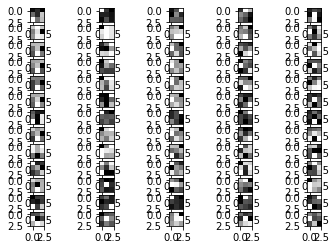

[[-0.18438907  0.37405285 -0.08257551]
 [-0.24271251  0.30180147 -0.24886157]
 [ 0.5097016   0.72604865  0.4111013 ]]
[[ 0.642611   -0.02434982 -0.6077416 ]
 [ 0.10758842  0.49639034 -0.01833885]
 [-0.25769007 -0.08715335 -0.28115588]]
[[ 0.6871713   0.07957743  0.7408401 ]
 [-0.08850713  0.41384694  0.08312844]
 [ 0.34243843 -0.17997162  0.04291648]]
[[-3.2370421e-01 -5.5671084e-01  2.2579098e-01]
 [ 3.6772129e-01 -2.0825010e-02  6.4107813e-02]
 [ 8.6161487e-02  2.1813899e-01  1.5567770e-04]]
[[-0.4165822  -0.31005043 -0.37812033]
 [-0.02631133 -0.16153197  0.06864267]
 [-0.49699795 -0.503809   -0.45025072]]


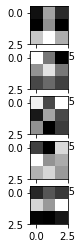

In [19]:
plot_weights(model)